## Introduction

The following document is the final Jupyter-Notebook submission file for group 3. For this exercise, we chose question 17 for our analysis, which includes a full investigation on modal split behaviour in various countries, what could potentially influence it, and how this tendency has changed over time. 

### Work management

As a group of four people, we have originally split the task into two groups: preprocessing and data visualizations. Two people would process a set of data, pass it to the visualization group, and then we would discuss what could be added, how we can draw conclusions from the current results, and what we could do to improve or add more insight to our understanding of the question. Naturally, we tried to help each other and give suggestions to improve/polish either groups work, so it was a continuous collaboration over the past few weeks. Especially when finalizing and combining the work, a lot of communication was necessary to properly combine each team members effort.

Throughout our collaboration in the team, we have circled the data science process several time (get data, process it, analyze it, understand that its not enough, get more data, analyze more, and repeat until you can make conclusions about the question under study) and only the final evaluations have made it into this document. We held meetings regularly (in 4-5 days interval) over Google Meet to discuss the current work process and to plan for the upcoming days. The progress was maintained on Github (see https://github.com/fardokhtsadat/DOPP for the full work progress). 

## What follows

What follows is the full data analysis that group 3 has conducted to answer question 17 of the third exercise. It goes from preprocessing all datasets, analyzing transport related data for various countries, investigating factors that could contribute to modal split tendencies, and finally analyses that helped us gain more insight into what factors have the biggest impact on modal split, and whether certain countries could be placed into similar groups. 

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import re
import json
import networkx as nx
import seaborn as sns

## Preprocessing

The datasets that we have taken into consideration for our analysis are retrieved from the Eurostat official website (https://ec.europa.eu/eurostat). The data is provided by the European Union and allows for standardized and comparative analysis of various research questions among countries in and around Europe. 

Our approach was to search for any, possibly relevant, transportation related data and find a unified approach of preprocessing all of them. We found several interesting datasets in regards to the: 

1. Modal split: proportions of vehicle type usage in various countries per year. 
2. Transportation infrastructure: motorway, railway, and air transportation information, including the length of motor or railways in countries and the kilometers undertaken by the citizens of a country per year. 
3. Country information: among those is the CO2-Emission created by a country, or the GDP of a country, or the deaths that have occured for certain vehicle types.

Below, you will find all preprocessing code listed. In order to create a standardized and "tidy" analysis, we organized the preprocessing general enough such that all datasets can be processed and transformed using the same functions. The explanation of the code is given below.  

In [2]:
def change_jsontypes(configuration):
    for key, value in configuration.items():
        if value == "True":
            configuration[key] = True
        elif value == "False":
            configuration[key] = False
        elif value == "None":
            configuration[key] = None
        else:
            continue

    return configuration

def exists(argument):
    if argument is not None:
        return True
    else:
        return False

def pipeline(path, split_which, split_by, keep_which, extract_which, info_cols, year_from, year_to, flip, melt_by, target_name, convert_which, aggregate_by, reshape_by):
    if exists(path): data = load_file(path)
    if exists(split_which): data = split_col(data=data, split_which=split_which, split_by=split_by, keep_which=keep_which)
    if exists(extract_which): data = extract_ctr_code(data=data, extract_which=extract_which)
    if exists(info_cols): data = assign_column_names(data=data, info_cols=info_cols, year_from=year_from, year_to=year_to, flip=flip)
    data = fill_nas(data=data)
    if exists(melt_by): data = melt_data(data=data, info_cols=info_cols, year_from=year_from, year_to=year_to, melt_by=melt_by,
                     target_name=target_name)
    data = drop_nas(data=data)
    if exists(convert_which): data = convert_to_numeric(data=data, convert_which=convert_which)
    if exists(aggregate_by): data = aggregate_sum(data=data, aggregate_by=aggregate_by)
    return data

def load_file(file_name=""):
    ### Loop the data lines
    with open(file_name, 'r') as temp_f: #e.g. "Co2Emissions/sdg_12_30.tsv"
        # get No of columns in each line
        col_count = [len(re.split('\s', l)) for l in temp_f.readlines()]

    ### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
    column_names = [i for i in range(0, max(col_count) - 1)]

    # Load data
    data = pd.read_csv(file_name, sep='\s', engine='python', header=None, names=column_names)
    data = data.drop(data.index[0])
    return data

def split_col(data=None, split_which=None, split_by=",", keep_which=None):
    data_split = data[split_which].str.split(",", expand=True)
    data_split = data_split.iloc[:, keep_which]
    data = data.drop(data.columns[[split_which]], axis=1)
    data = pd.concat([data_split, data], ignore_index=True, sort=False, axis=1)
    return data

def extract_ctr_code(data=None, extract_which=None):
    data.iloc[:, extract_which] = data.iloc[:,extract_which].str[:2]
    return data

def assign_column_names(data=None, info_cols=[], year_from=None, year_to=None, flip=False):
    # Preprocess and assign column names
    # NOTE: status variable stores the information of the data point status, i.e. is the data successfully retrieved (NaN), estimated (e), definition differs (d), not applicable (z), definition differs and estimated (de), or break in time series and estimated (be)
    if flip:
        years = np.flip(np.arange(year_from, year_to+1))
    else:
        years = np.arange(year_from, year_to+1)
    status = np.full((1, years.size), [str(year) + '_status' for year in years])
    cols = np.empty((years.size + status.size,), dtype=status.dtype)
    cols[0::2] = years
    cols[1::2] = status

    # Stack the two data frames horizontally
    data.columns = info_cols + cols.tolist()
    return data

def fill_nas(data=None):
    return data.fillna('ok').replace(':', np.nan)

def drop_nas(data=None):
    return data.dropna()

def convert_to_numeric(data=None, convert_which=None):
    data[convert_which] = pd.to_numeric(data[convert_which], downcast="float")
    return data

def aggregate_sum(data=None, aggregate_by=None):
    return data.groupby(aggregate_by).sum().reset_index()

def melt_data(data=None, info_cols=None, year_from=None, year_to=None, melt_by=None, target_name=None):
    data = data[info_cols + [str(year) for year in np.arange(year_from,year_to+1)]]. \
        melt(info_cols, var_name=melt_by, value_name=target_name)
    return data

def reshape_data(data=None, reshape_by=None):
    return data.set_index(reshape_by).unstack().reset_index()


In [3]:
configuration = "related_to_transport.json"
dataframes = []
with open(configuration) as config_file:
    config_file = json.load(config_file)

for dataset in config_file:
    configuration = change_jsontypes(config_file[dataset])

    data = pipeline(path=configuration['path'],
                    split_which=configuration['split_which'],
                    split_by=configuration['split_by'],
                    keep_which=configuration['keep_which'],
                    extract_which=configuration['extract_which'],
                    info_cols=configuration['info_cols'],
                    year_from=configuration['year_from'],
                    year_to=configuration['year_to'],
                    flip=configuration['flip'],
                    melt_by=configuration['melt_by'],
                    target_name=configuration['target_name'],
                    convert_which=configuration['convert_which'],
                    aggregate_by=configuration['aggregate_by'],
                    reshape_by=configuration['reshape_by'])

    data.to_csv("RelatedToTransport/"+dataset+".csv", index=False)

    #Prepare datasets to be joined all together by Year and Country.
    data.columns = [dataset+"_"+col if col not in ['Year', 'Country'] else col for col in data.columns.to_list()]
    dataframes.append(data)

dataframes = [df.set_index(['Country', 'Year']) for df in dataframes]
joined_df = dataframes[0].join(dataframes[1:], how="outer").reset_index()
joined_df.to_csv("RelatedToTransport/All_data_outer_join_by_country_and_year.csv", index=False)
joined_df = dataframes[0].join(dataframes[1:], how="inner").reset_index()
joined_df.to_csv("RelatedToTransport/All_data_inner_join_by_country_and_year.csv", index=False)

### Preprocessing code explanation

We solved the problem of unifying and standardizing the preprocessing step by creating a "configuration" JSON file, which will record what preprocessing steps are necessary for each dataset.

For example, one entry looks like the following:

```json
"ModalSplit": {
        "path": "RelatedToTransport/ModalSplit.tsv",
        "split_which" : 0,
        "split_by" : ",",
        "keep_which" : [1,2],
        "extract_which" : "None",
        "info_cols" : ["VehicleType", "Country"],
        "year_from" : 1990,
        "year_to" : 2019,
        "flip" : "True",
        "melt_by" : "Year",
        "target_name" : "ModalSplitKm",
        "convert_which" : "ModalSplitKm",
        "aggregate_by" : "None",
        "reshape_by" : ["Year", "Country", "VehicleType"]
}
```

The JSON configuration listed above describes what preprocessing steps will occur for the Modal Split dataset that we retrieved from Eurostat. It mentions the path to the dataset, whether and which columns of the data have to be split, which columns are informative and should be kept, how and by which columns should the data be aggregated, and more. 

Altogether, each dataset is transformed into a plot-able dataframe, which means that we format individual columns, remove missing values, and finally reshape the dataframe in order to create a table that has information sorted by informative columns (Year, Country, Unit1, Unit2, ..., Measurement 1, Measurement 2, ...). 

The goal for us was to develop a preprocessing pipeline, which is general enough to preprocess any dataset stored in Eurostat by simply adding a new configuration item into the "related_to_transport.json" file. 

### Reasoning behind missing value treatment

As it was shortly mentioned in the management summary, we have decided to completely remove missing rows from our analysis, instead of imputing them. This means that if a country has missing values for a certain number of years, those will be removed from the analysis. The implication is that for several countries, the study period is not from 1990-2020, but starts from e.g. 1998, 2004, or 2009 up until 2020. 

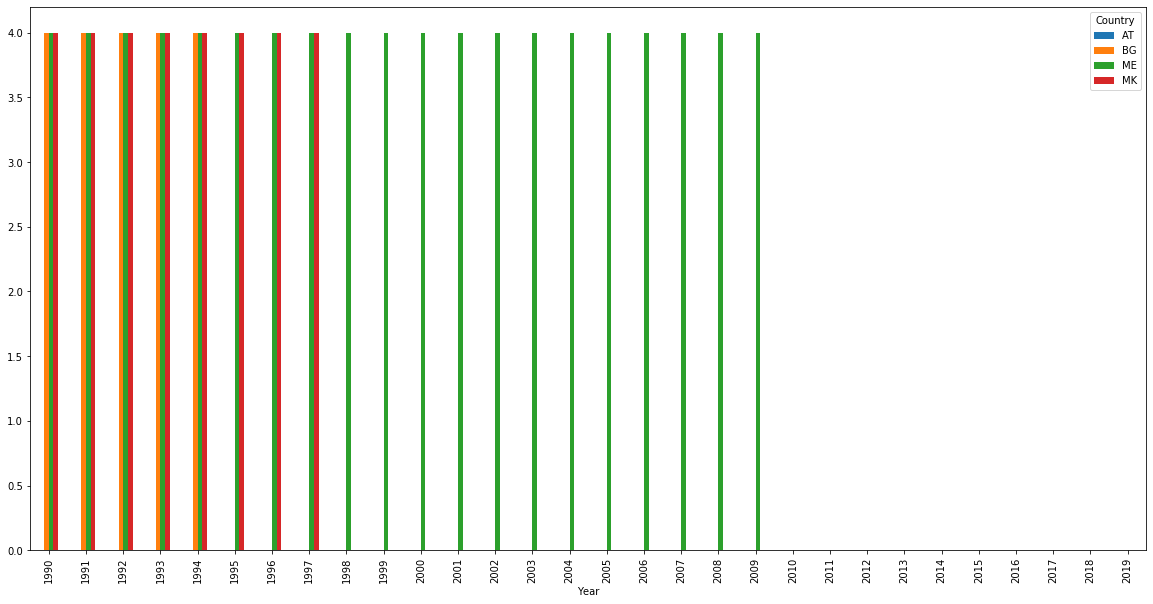

In [4]:
missing_data=pd.read_csv("RelatedToTransport/MODSPLIT_missing_data_per_country_per_year.csv")
missing_data = missing_data.loc[missing_data['Country'].isin(['AT', 'BG', 'MK', 'NT', 'ME'])]
missing_data.pivot_table('Missing', ['Year'], 'Country').plot.bar(figsize=(20,10))

Four countries are listed above as an example for missing values. Austria does not have any missing information and therefore is not visible in the plot at all. Bulgaria, North Macedonia, and Montenegro are additionally shown having 5, 8, and 20 consecutive years of missing data, respectively. 

According to the distribution of those missing values, it is not desirable to impute them, as they are not occuring inbetween years, but are a set of consecutively missing values at the beginning of the study period. 

Additionally, special care had to be taken in the definition of "missing" in this case, because all of these countries had various transportation types in those years, but the effort to record such data in a standardized manner has not been established in all countries at the same time point. Moreover, the Eurostat data already denotes different kinds of missing values, out of which a data point can be:

1. Missing due to lack of infrastructure (the case above)
2. Missing but estimated according to standardized measures developed by the European Union
3. Missing, because the actual transportation form does not exist in a certain country - like train transportation in Malta, Iceland, or Cyprus

Taking these different kinds of missing values into account, we opted for missing value removal instead of imputation for case 1, took the estimated values provided by Eurostat for case 2, and analyzed only relevant transportation types for countries in case 3.  

## Modal Split

### Modal split analysis on european level

As we are studying the modal split behaviour in European countries, it is important to get an overall impression of modal split tendencies across Europe overall. Therefore, we first analyze the modal split change as an average over all European countries, and then inspect each country individually.

The plot below depicts how the distribution of user preference has changed (in percentages) among different types of transport (Car, Bus or Train).

In [5]:
#load dataset
df_modal_split=pd.read_csv("RelatedToTransport/ModalSplit.csv")

In [6]:
#examine data structure for a country
df_modal_split[df_modal_split["Country"]=="AT"].head(10)

VehicleType Country  Year  ModalSplitKm
0            BUS_TOT      AT  1990           8.2
19               CAR      AT  1990          79.6
38               TRN      AT  1990          12.3
57   TRN_BUS_TOT_AVD      AT  1990          20.4
76           BUS_TOT      AT  1991           8.1
93               CAR      AT  1991          79.2
110              TRN      AT  1991          12.7
127  TRN_BUS_TOT_AVD      AT  1991          20.8
144          BUS_TOT      AT  1992           8.2
164              CAR      AT  1992          79.0

In [7]:
#restructure columns for the bar plot
modal_europe_yearly=df_modal_split[df_modal_split["Country"]=="EU27_2020"].pivot_table("ModalSplitKm",["Year"],"VehicleType")
#remove last column
del modal_europe_yearly["TRN_BUS_TOT_AVD"]
#add year column
modal_europe_yearly["Year"]=modal_europe_yearly.index.values
modal_europe_yearly.head(10)

VehicleType  BUS_TOT   CAR  TRN  Year
Year                                 
2000            11.0  81.6  7.4  2000
2001            10.8  82.0  7.3  2001
2002            10.5  82.5  7.0  2002
2003            10.4  82.8  6.8  2003
2004            10.4  82.7  6.9  2004
2005            10.4  82.6  7.0  2005
2006            10.2  82.6  7.1  2006
2007            10.4  82.3  7.2  2007
2008            10.4  82.2  7.4  2008
2009             9.7  83.2  7.1  2009

Text(0, 0.5, 'Percentage')

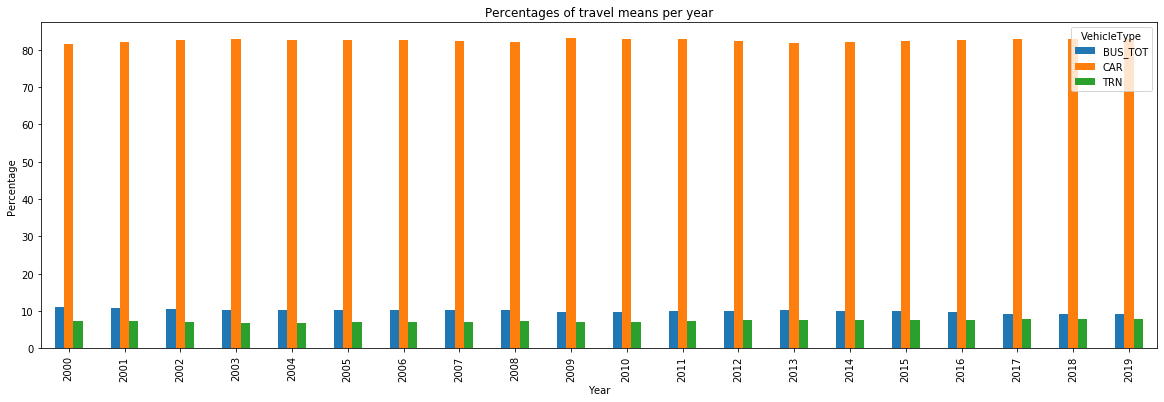

In [8]:
# plot grouped bar chart
modal_plot=modal_europe_yearly.plot(x='Year',
        kind='bar',
        stacked=False,
        title='Percentages of travel means per year',
                        figsize=(20,6))
modal_plot.set_ylabel("Percentage")

In [9]:
modal_europe_yearly.head(10)

VehicleType  BUS_TOT   CAR  TRN  Year
Year                                 
2000            11.0  81.6  7.4  2000
2001            10.8  82.0  7.3  2001
2002            10.5  82.5  7.0  2002
2003            10.4  82.8  6.8  2003
2004            10.4  82.7  6.9  2004
2005            10.4  82.6  7.0  2005
2006            10.2  82.6  7.1  2006
2007            10.4  82.3  7.2  2007
2008            10.4  82.2  7.4  2008
2009             9.7  83.2  7.1  2009

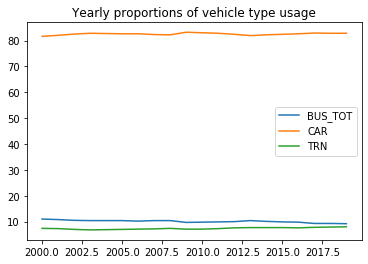

In [10]:
modalities=["BUS_TOT","CAR","TRN"]
for i in modalities:
    plt.plot(modal_europe_yearly["Year"],modal_europe_yearly[i], label=i)
plt.legend(loc="center right")
plt.title("Yearly proportions of vehicle type usage")
plt.show()

### Notes on the european modal split average

The above shown plots visualize the vehicle type usage for all European countries as a whole. On average, European citizens largely utilize car transportation as their main form of transport, with bus and train transportation only making up about 10% of usage. Over the course of 20 years, the usage distributation remains steady for car transportation, decreases in time for the bus transport, and slightly increases for the train transport. Naturally, considering modal split as an average over 27 countries merely gives an approximate overview, but does not show the tendencies of individual countries. As long as the data is aggregated on the level of Europe, no clear trend is yet visible in regards to how the modal split behaviour changes over time for individual countries. 

Therefore, we move on to study the modal split per country. 

### Modal split analysis on country level

Let's now examine the modal split distribution in every country individually. Note that only a selection of countries is shown below, due to the large number of countries plotted. For the interpretations, nevertheless, all countries have been taken into consideration, but only a set of examples is presented here.

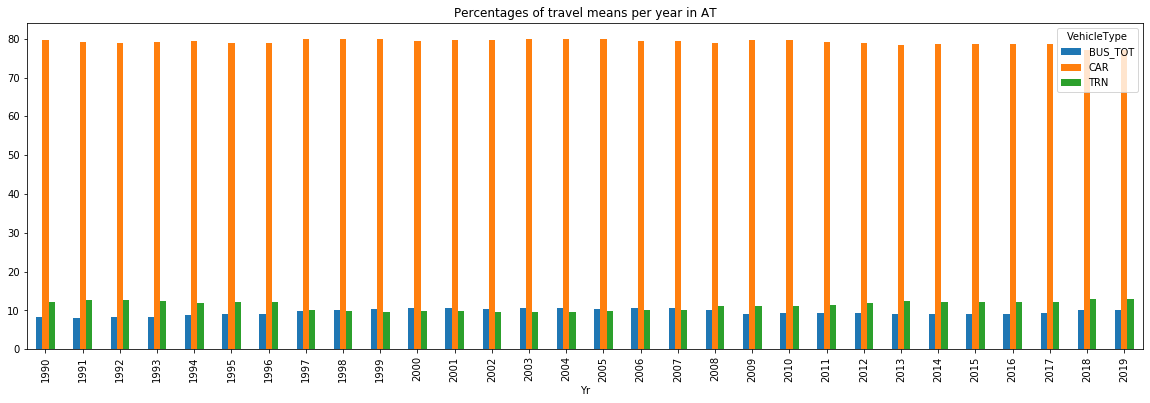

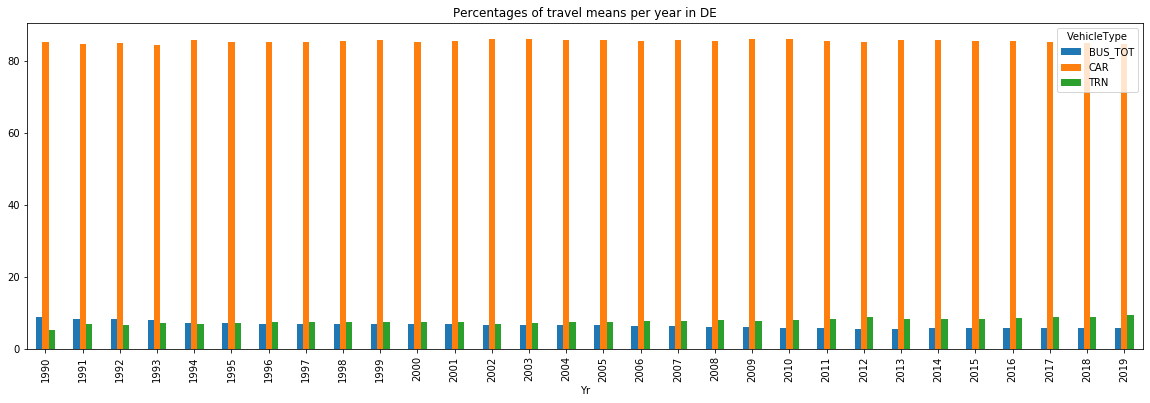

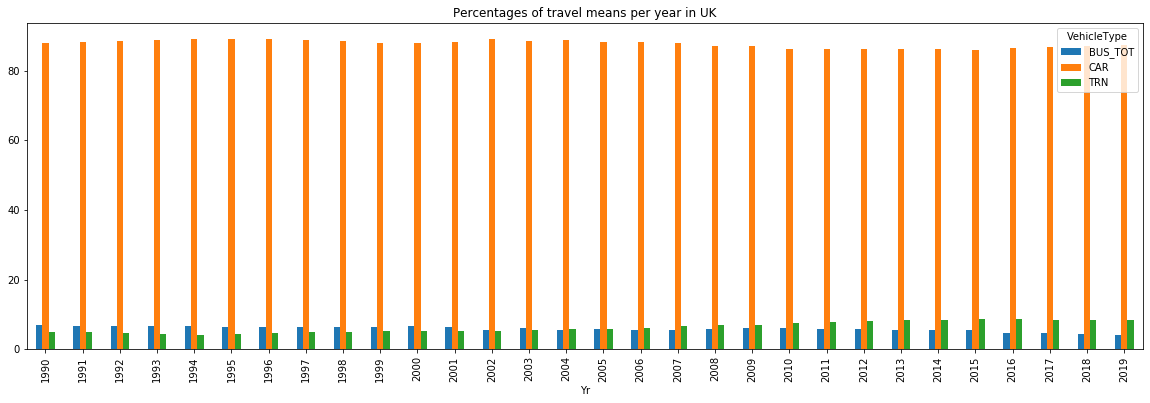

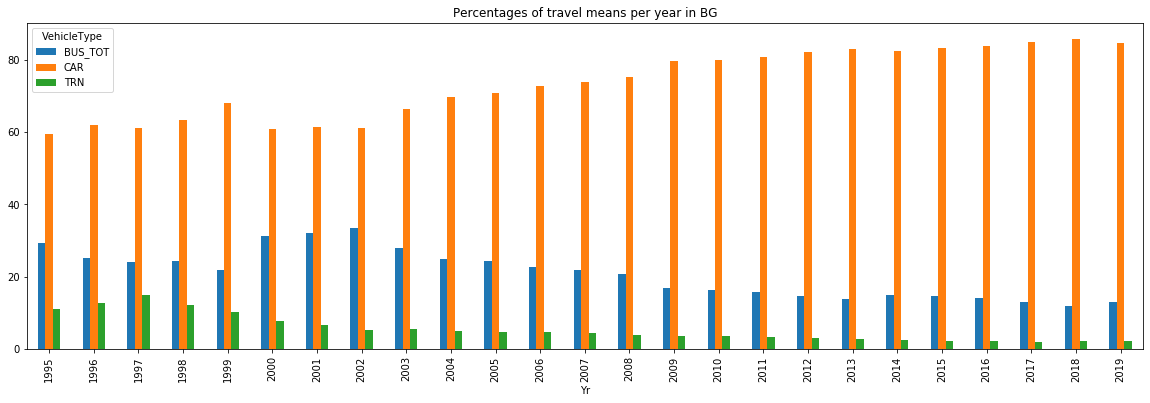

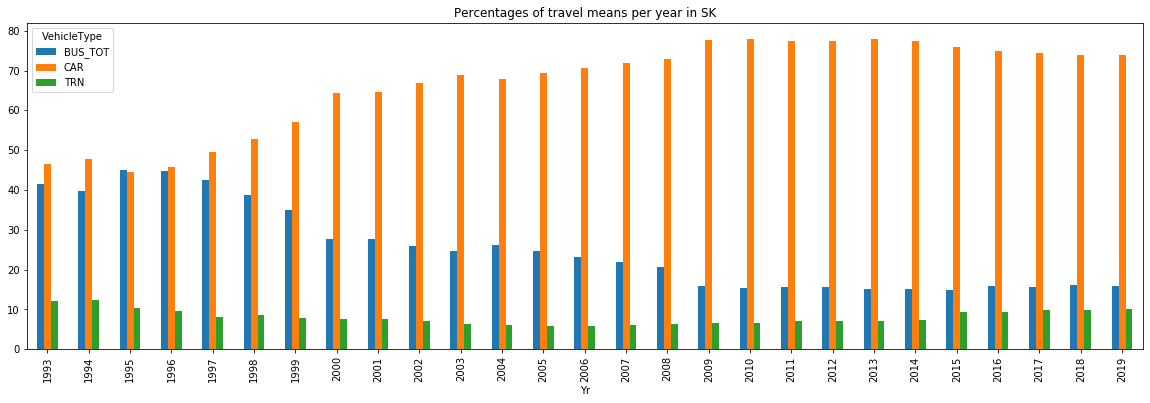

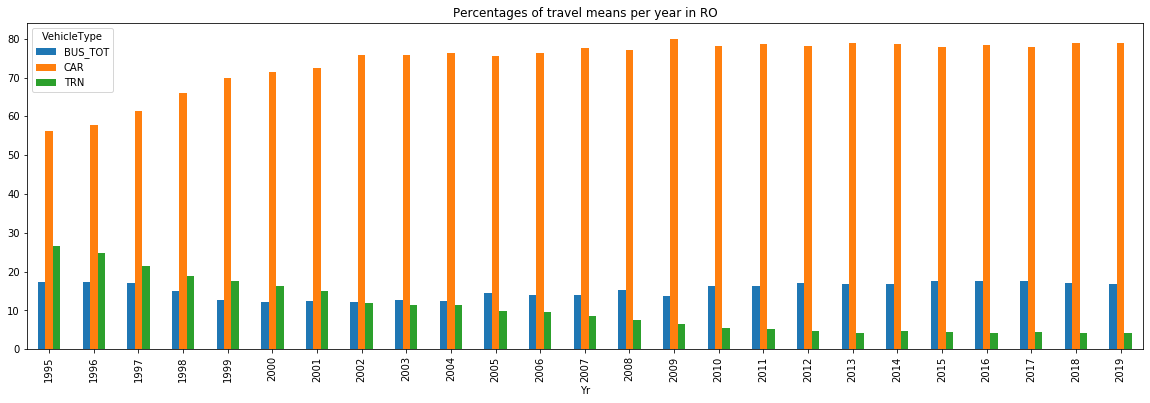

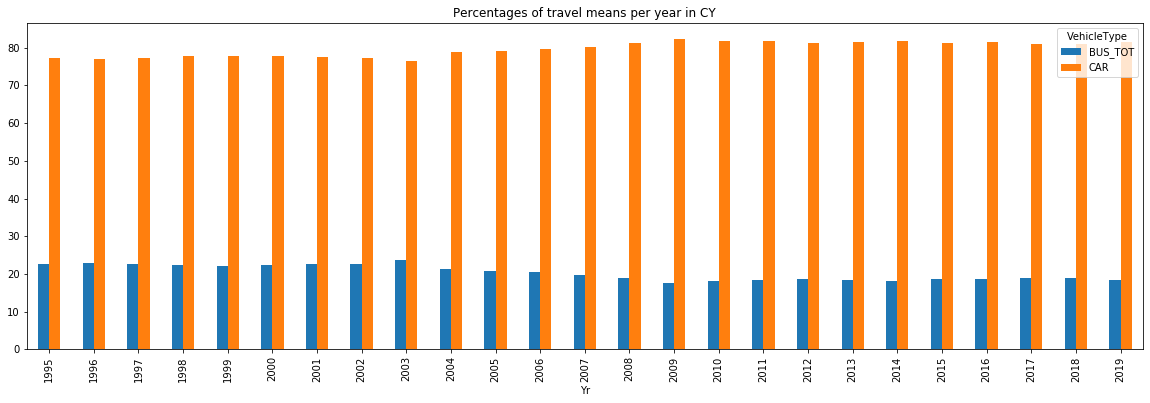

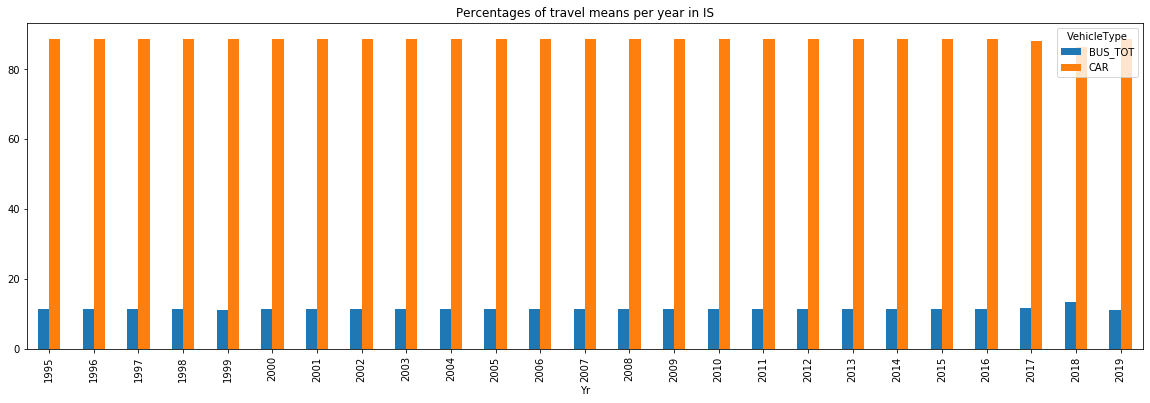

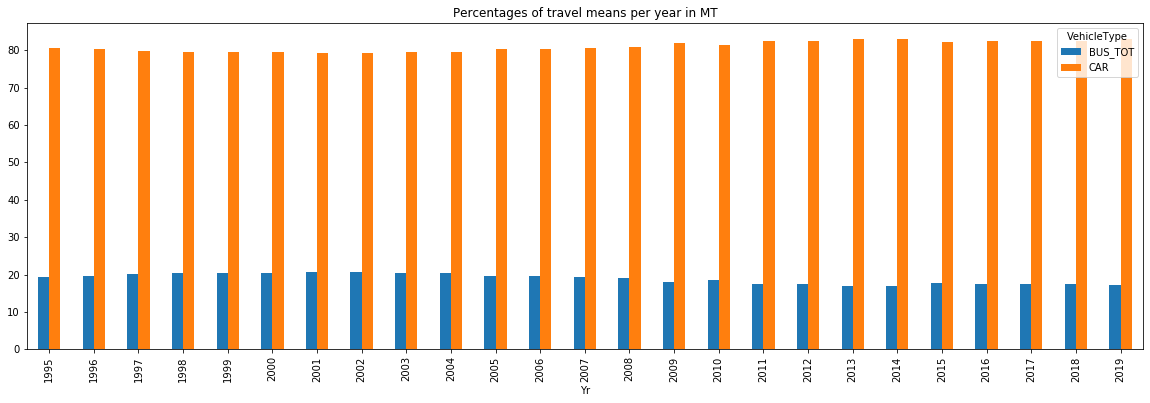

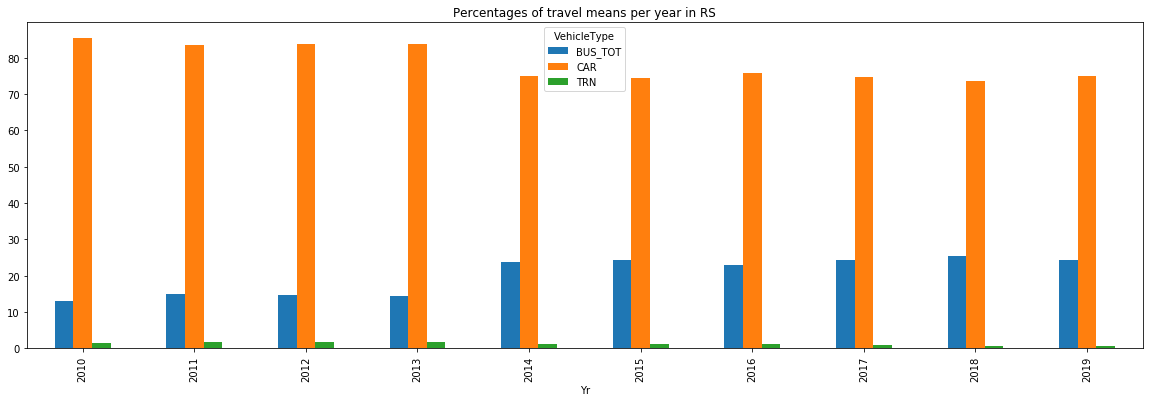

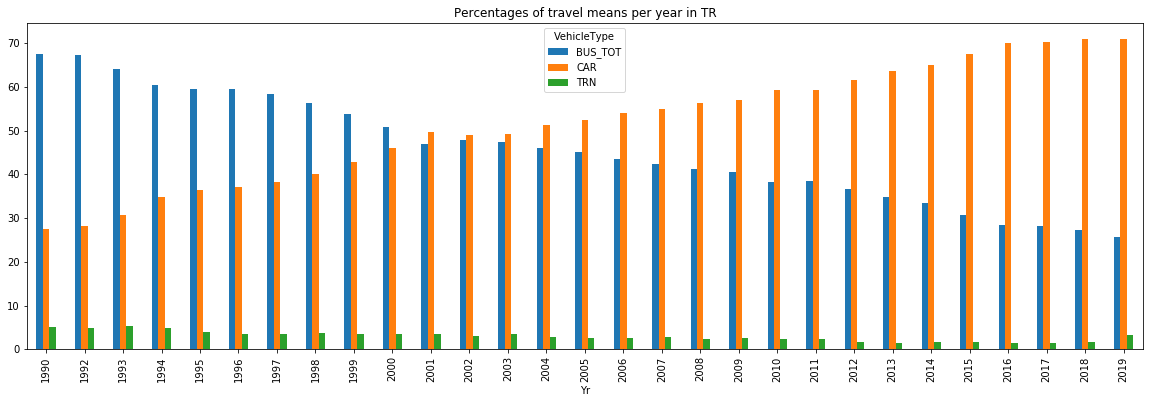

In [11]:
def plot_modal_split_all_countries():
    #countries=df_modal_split["Country"].unique()    
    countries = ["AT", "DE", "UK", "BG", "SK", "RO", "CY", "IS", "MT", "RS", "TR"]
    for cnt in countries:
        modal_europe_yearly=df_modal_split[df_modal_split["Country"]==cnt].pivot_table("ModalSplitKm",["Year"],"VehicleType")
        #remove last column
        del modal_europe_yearly["TRN_BUS_TOT_AVD"]
        #add year column
        modal_europe_yearly["Yr"]=modal_europe_yearly.index.values
        modal_plot=modal_europe_yearly.plot(x='Yr',
            kind='bar',
            stacked=False,
            title='Percentages of travel means per year in '+cnt,
                        figsize=(20,6))

        
plot_modal_split_all_countries()       


In Bulgaria (BG), Slovakia (SK), and Romania (RO) we can see an increase in car usage and a decrease in train and bus usage. Some countries like Cyprus (CY), Iceland (IS) and Malta (MT) don't have train infrastructure whatsoever, which could be explained by the small size or special geographic location of those countries. Serbia (RS) is the only country that shows a decrease in car usage over time. In Turkey, there has been a two-fold increase in car transport usage, while bus transport usage decreased to less than a half than it was at the beginning of the study period. 

Generally, countries located in Western Europe tend to have car transportation as their main use, with other transportation types (bus, train) remaining steady over time. Countries located in Eastern Europe tend to use other transportations besides car more extensively, but even here the transportation via car remains the most dominant type. Several countries - such as Turkey, Slovakia, or Romania - exhibit a very interesting switch in modal split over time. 

As mentioned already, Turkey's transport type usage was by bus up until 2001, but resulted in a decrease of bus transportation by more than half of the starting proportion in 1990. In Romania, train transportation has been decreasingly used over time, and car transport is consistently the most dominant type. Lastly, Slovakia experienced a full switch in transport usage between bus and train, where in earlier years bus transportation was used more, but as time passed the tendency to train transport increased.


## Factors that could affect or be a result of modal split change in various countries

Knowing the modal split behaviour of certain groups of countries raises the question of whether there are any factors that contribute to this tendency. In our analysis, we tried to consider different kinds of transport-related data, in addition to datasets describing countries by other factors such as GDP or CO2 emissions. 

The main factors we focused on were: 

1. Transportation infrastructure of a country: railway, motorway, and airway networks provided by and used in a country
2. GDB of a country 
3. Road traffic deaths
4. CO2 emissions


### Train transport usage per country

The following visualization depicts the absolute number of kilometers undertaken in millions per country, and is supposed to present overall train usage in a country. 

In [12]:
#load dataset
df_train = pd.read_csv("RelatedToTransport/RailwayTransport.csv")
df_train = df_train[~df_train['Country'].astype(str).str.startswith('EU2')]

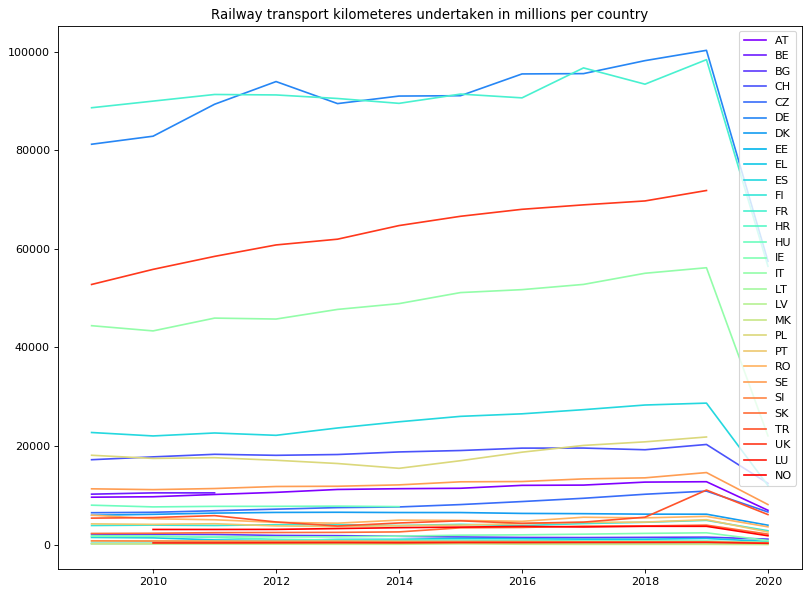

In [13]:
def plot_train_traffic_by_country(plot_title):  
    figure(figsize=(12, 9), dpi=80)
    #get list of countries
    countries=df_train["Country"].unique()
    n=len(countries)
    #generate colors
    color = cm.rainbow(np.linspace(0, 1, n))
    i=0
    for country in countries:    
        plt.plot(df_train[df_train["Country"]==country]["Year"],df_train[df_train["Country"]==country]["RailwayTransportKm"],c=color[i],label=country)
        i=i+1
    #show legend
    plt.legend(loc='upper right')    
    plt.title(plot_title)
    plt.show()
plot_train_traffic_by_country  ("Railway transport kilometeres undertaken in millions per country")  

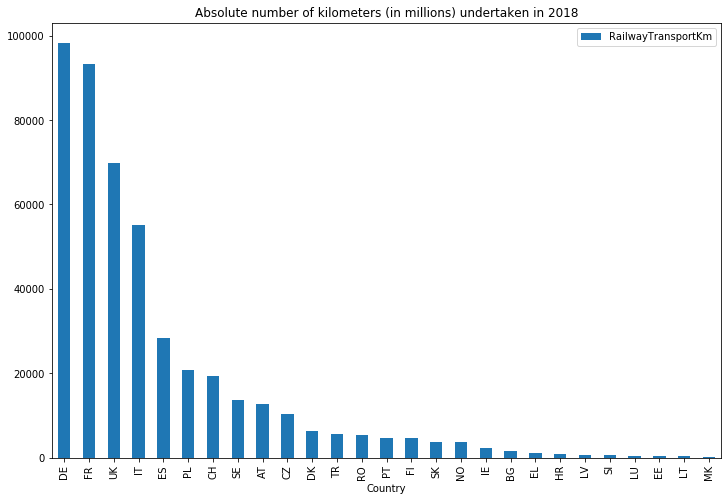

In [14]:
train_usage_2018=df_train[df_train["Year"]==2018].drop(labels="Year", axis=1,inplace=False).sort_values(by="RailwayTransportKm", ascending=False).set_index("Country")
train_usage_2018.plot.bar(figsize=(12,8), title="Absolute number of kilometers (in millions) undertaken in 2018")

In [15]:
df_population = pd.read_csv("RelatedToTransport/Population.csv")
df_population_five = df_population[df_population["Year"].isin([2016, 2017, 2018, 2019, 2020])]
dataframes = [df_train, df_population_five]
dataframes = [df.set_index(['Country', 'Year']) for df in dataframes]
joined_df = dataframes[0].join(dataframes[1], how="inner").reset_index()
joined_df["RelativeTransportKm"] = joined_df["RailwayTransportKm"]/joined_df["PopulationCount"]

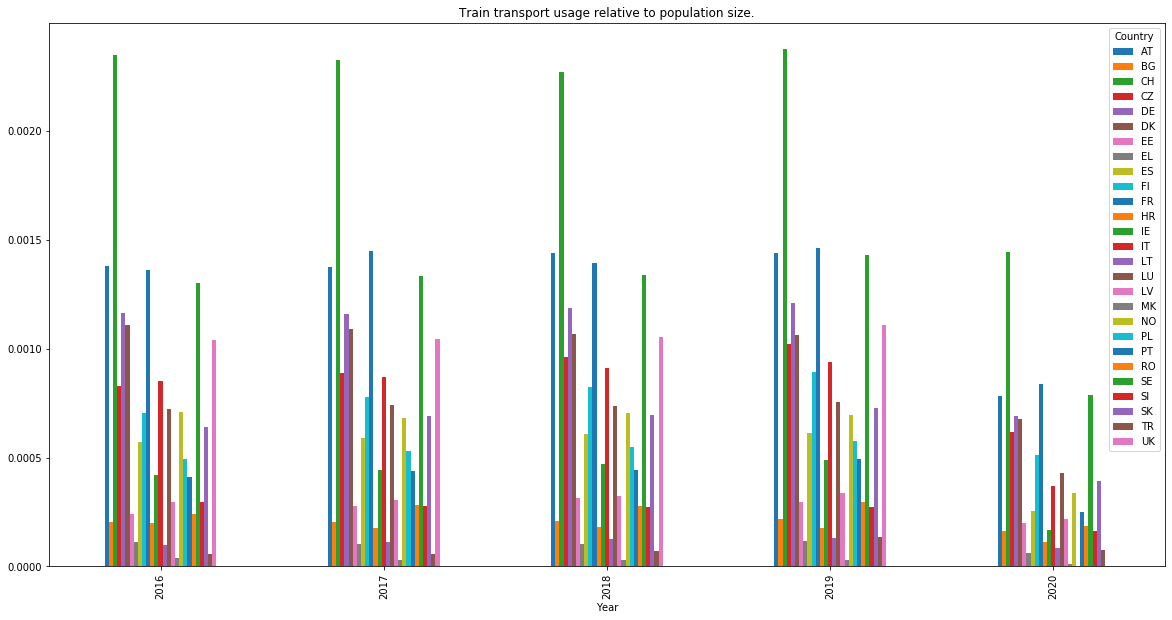

In [16]:
relative_train_use=joined_df.drop(labels=["RailwayTransportKm", "PopulationCount"], axis=1).sort_values(by=["RelativeTransportKm"], ascending=False)
relative_train_use=relative_train_use.sort_values(by=["Year", "RelativeTransportKm"], ascending=[True,False])
relative_train_use.pivot_table('RelativeTransportKm', ['Year'], 'Country').plot.bar(figsize=(20,10), title = "Train transport usage relative to population size.")

The purpose of analyzing this train data was to see whether we could detect countries with interesting changes in train usage. Nevertheless, it does not seem the case: there is an overall increasing trend in train usage for most countries, but we could not see significant changes in train usage. 

We analyzed the amount of kilometers made per country for 2018 in a histogram to provide a better per-country comparison. Overall, larger countries in Western Europe (Germany, France, United Kingdom, ...) have a relatively higher train-transport usage, but relative to the population, train usage differs considerably. 

In the last plot, we plot the train usage relative to the population size of the country. Switzerland has by far the strongest use of train transportation relative to its population size, followed by France and Austria (both have blue as colors, so the shade is difficult to distinguish). Turkey (TR), Lithuania (LT), and Belgium (EL) have the lowest relative usage in trains. 

All countries experience a significant decline in 2020, which could be explained by the Covid-Pandemic that has been affecting the global economy, and especially Europe since March 2020. 

# Air transport usage per country

Nowadays, air transportation has become increasingly popular even for shorter distances. Many people choose to fly even national flights, because they have become considerably cheaper and more convenient to use. The effect of such a trend could indirectly affect the transportation-type choice of citizens, and could explain a decreased use of other transportation types. In this section, we analyze the air transportation kilometers (in millions) made per country.  

In [17]:
df_air=pd.read_csv("RelatedToTransport/AirTransport.csv")
df_air.head(10)

Country  Year  AirTransportKm
0      AT  2009      21817268.0
1      BE  2009      21316690.0
2      BG  2009       5840825.0
3      CH  2009      35928170.0
4      CY  2009       6729787.0
5      CZ  2009      12367467.0
6      DE  2009     158148830.0
7      DK  2009      22277524.0
8      EE  2009       1341294.0
9      EL  2009      33440268.0

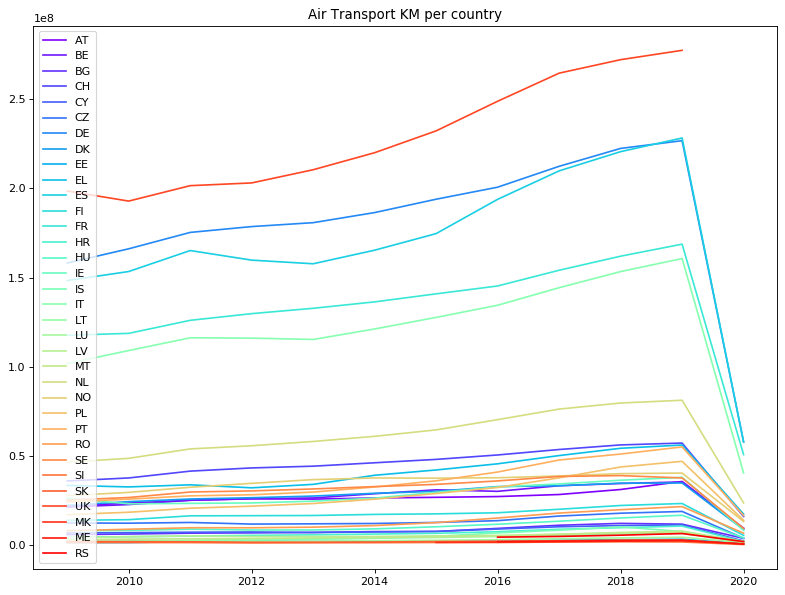

In [18]:
def plot_air_transport_by_country(plot_title):  
    figure(figsize=(12, 9), dpi=80)
    #get list of countries
    countries=df_air["Country"].unique()
    countries=np.delete(countries,[11,12,13])
    n=len(countries)
    #generate colors
    color = cm.rainbow(np.linspace(0, 1, n))
    i=0
    for country in countries:    
        plt.plot(df_air[df_air["Country"]==country]["Year"],df_air[df_air["Country"]==country]["AirTransportKm"],c=color[i],label=country)
        i=i+1
    #show legend
    plt.legend(loc='upper left')
    plt.title(plot_title)
    plt.show()
    
plot_air_transport_by_country  ("Air Transport KM per country")  

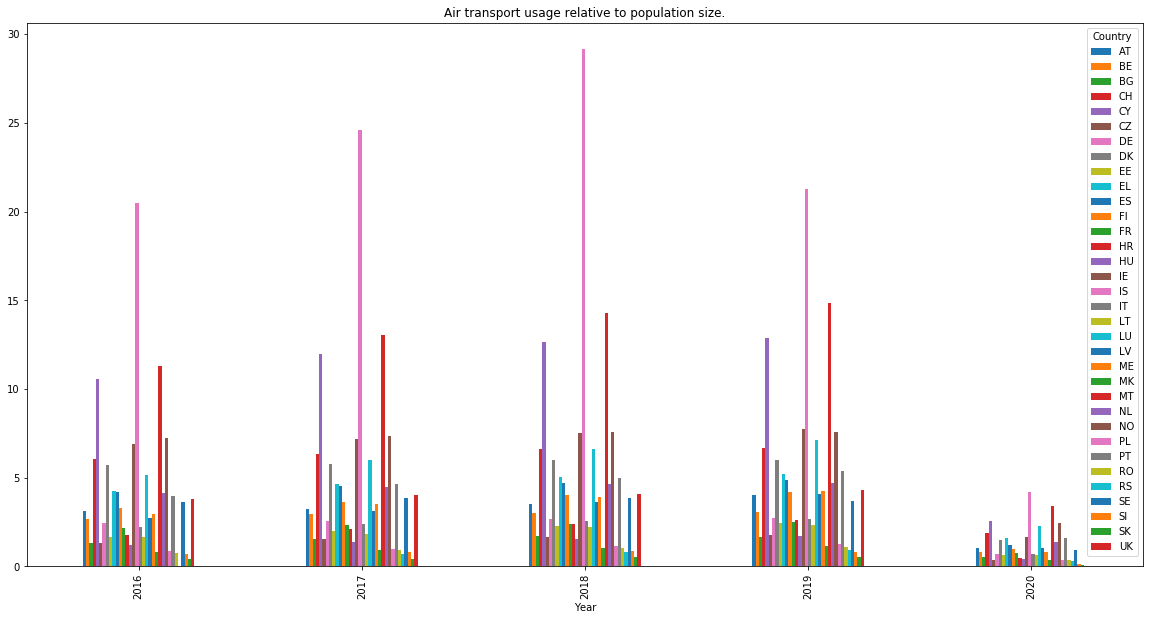

In [19]:
dataframes = [df_air, df_population_five]
dataframes = [df.set_index(['Country', 'Year']) for df in dataframes]
joined_df = dataframes[0].join(dataframes[1], how="inner").reset_index()
joined_df["RelativeTransportKm"] = joined_df["AirTransportKm"]/joined_df["PopulationCount"]
relative_train_use=joined_df.drop(labels=["AirTransportKm", "PopulationCount"], axis=1).sort_values(by=["RelativeTransportKm"], ascending=False)
relative_train_use=relative_train_use.sort_values(by=["Year", "RelativeTransportKm"], ascending=[True,False])
relative_train_use.pivot_table('RelativeTransportKm', ['Year'], 'Country').plot.bar(figsize=(20,10), title = "Air transport usage relative to population size.")

Similar to the train transport usage, air transportation has become more important and frequently used over time, up until the Covid pandemic in 2020. 

In contrast to the train data, we can observe a completely different set of countries that make up the peak of air transportation use. Interestingly, the three top countries are Iceland (IS), Malta (MT), Cyprus (CY) - **which don't have any train infrastructure at all!** Other countries that are close to the three exceptional cases are Norway (NO), Ireland (IE), Switzerland (CH), Denmark (DK), and Luxemburg (LU). The countries with lowest usage in air transportation relative to population size are Slovakia, Slovenia, Serbia, and North Macedonia. 


# Data road traffic deaths

In addition to the transportation infrastructure related data, we thought it would also be interesting to study how the number of road traffic deaths have changed over the years. Depending on the course of change in deaths, one might be able to correlate it to e.g. to the amount of car transportation usage in a country.

Below, the road deaths in European countries are analyzed. According to the Eurostats, a road death in this data collection includes any death that occurs up to 30 days of an accident that involved drivers, passengers, pedal cycles, as well as pedestrians. We visualize this data i) as total road deaths per country, and ii) as the relative number of road deaths relative to the population size.  

In [20]:
df_road_deaths=pd.read_csv("RelatedToTransport/RoadTrafficDeaths.csv")

In [21]:
df_road_deaths=df_road_deaths[df_road_deaths["TypeOfRoad"]=="TOTAL"]
df_road_deaths[df_road_deaths["Unit"]=="RT"].head(10)

TypeOfRoad Unit Country  Year  RoadTrafficDeaths
148      TOTAL   RT      AT  2000               12.2
149      TOTAL   RT      BE  2000               14.3
150      TOTAL   RT      BG  2000               12.4
151      TOTAL   RT      CH  2000                8.2
152      TOTAL   RT      CY  2000               16.0
153      TOTAL   RT      CZ  2000               14.5
154      TOTAL   RT      DE  2000                9.1
155      TOTAL   RT      DK  2000                9.3
156      TOTAL   RT      EE  2000               14.6
157      TOTAL   RT      EL  2000               18.9

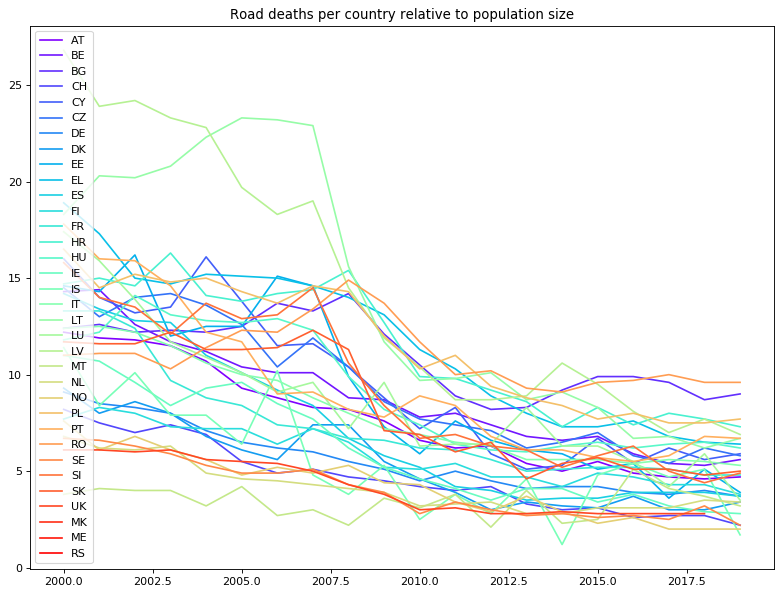

In [22]:
def plot_road_deaths_by_country_rt_unit(plot_title):  
    figure(figsize=(12, 9), dpi=80)
    #get list of countries
    countries=df_air["Country"].unique()
    countries=np.delete(countries,[11,12,13])
    n=len(countries)
    #generate colors
    color = cm.rainbow(np.linspace(0, 1, n))
    i=0
    for country in countries:    
        plt.plot(df_road_deaths[df_road_deaths["Unit"]=="RT"][df_road_deaths[df_road_deaths["Unit"]=="RT"]["Country"]==country]["Year"],df_road_deaths[df_road_deaths["Unit"]=="RT"][df_road_deaths[df_road_deaths["Unit"]=="RT"]["Country"]==country]["RoadTrafficDeaths"],c=color[i],label=country)
        i=i+1
    #show legend
    plt.legend(loc='upper left')
    plt.title(plot_title)
    plt.show()
    
plot_road_deaths_by_country_rt_unit("Road deaths per country relative to population size")  

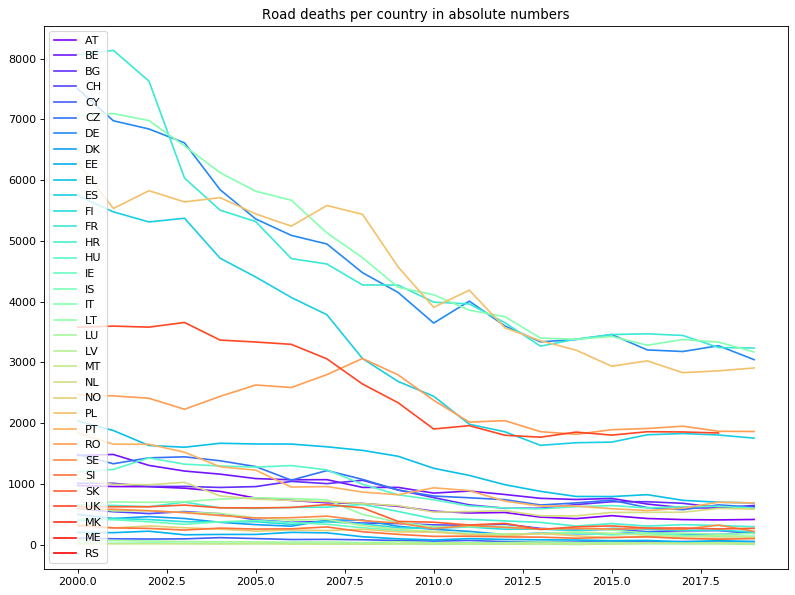

In [23]:
def plot_road_deaths_by_country_nr_unit(plot_title):  
    figure(figsize=(12, 9), dpi=80)
    #get list of countries
    countries=df_air["Country"].unique()
    #delete EU aggregated data
    countries=np.delete(countries,[11,12,13])
    n=len(countries)
    #generate colors
    color = cm.rainbow(np.linspace(0, 1, n))
    i=0
    for country in countries:    
        plt.plot(df_road_deaths[df_road_deaths["Unit"]=="NR"][df_road_deaths[df_road_deaths["Unit"]=="NR"]["Country"]==country]["Year"],df_road_deaths[df_road_deaths["Unit"]=="NR"][df_road_deaths[df_road_deaths["Unit"]=="NR"]["Country"]==country]["RoadTrafficDeaths"],c=color[i],label=country)
        i=i+1
    #show legend
    plt.legend(loc='upper left')
    plt.title(plot_title)
    plt.show()
    
plot_road_deaths_by_country_nr_unit("Road deaths per country in absolute numbers")  

In general, road traffic deaths have decreased in time. Countries like France (FR), Germany (DE), Italy (IT), and Poland (PL) have had the highest absolute numbers in road traffic death, but have decreased the amount to half of the numbers in about 17 years.  

Relative to the population, Latvia (LV), Lithuania (LT), Greece (EL), and Portugal (PT) have had the highest proportion of road deaths, and similarly to the top countries in absolute numbers, they were also able to cut the number of road deaths in half. 

From the investigations we have made up to this point, it is doubtful that the significant decrease in road deaths is connected to people using other transports, but is most probably attributable to the safer cars that have developed over the past 20 years. 

To further support this argument, we have visualized the relative road deaths in comparison to the modal split proportions we are already aware of. As shown below, even though the road deaths significantly decrease in time, the car usage in most countries actually increases or at least remains steady over the course of the last 20 years. 

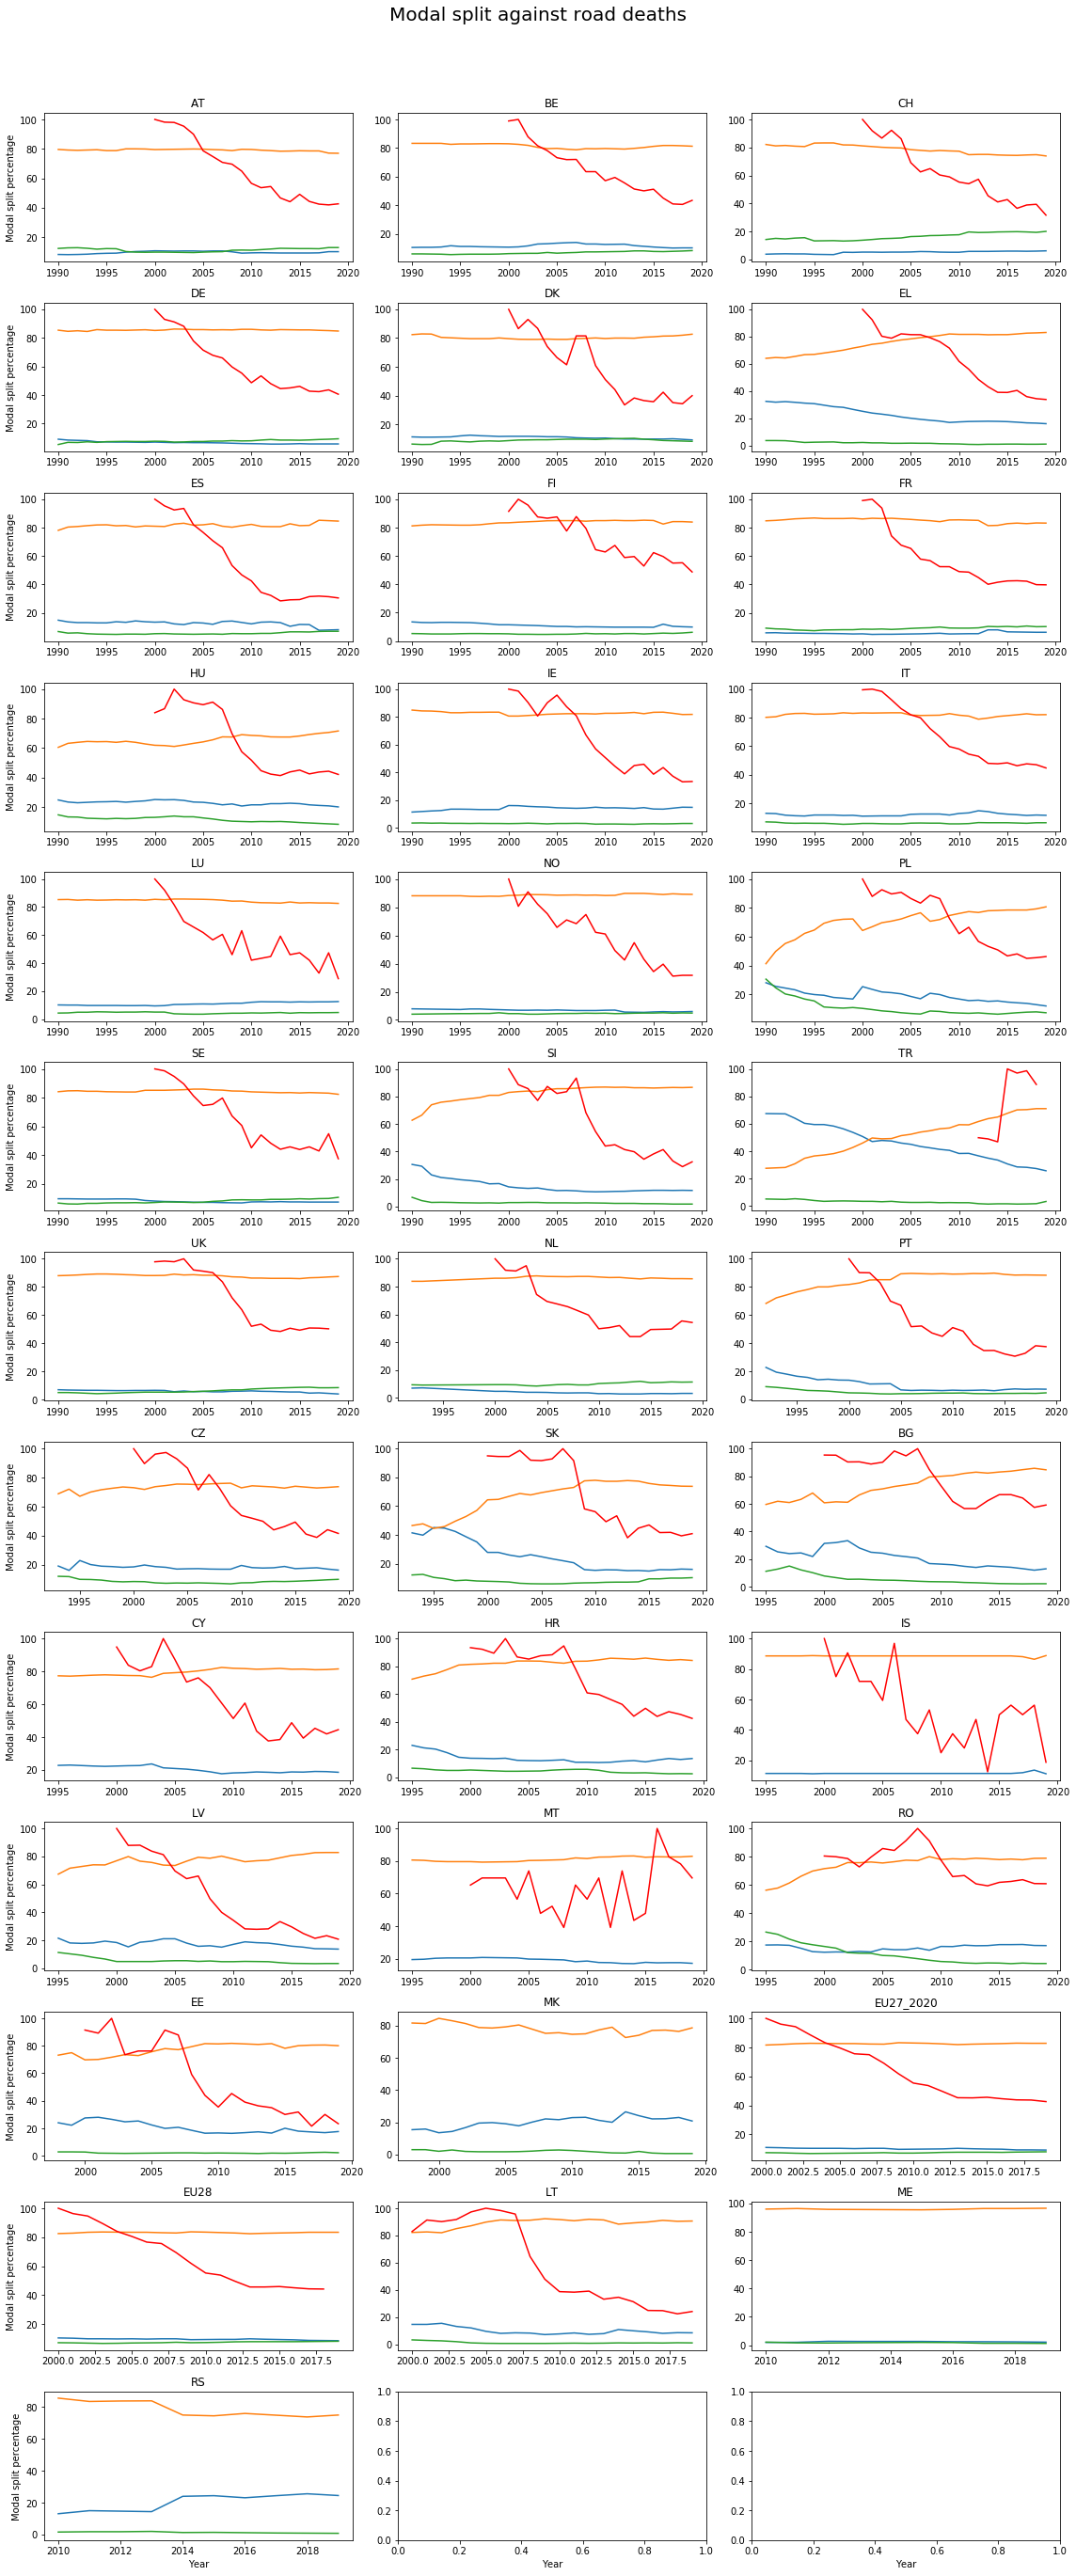

In [24]:
df_modal_split_km=pd.read_csv("RelatedToTransport/ModalSplit.csv")
def plot_modal_split_road_deaths_comparison():
    countries=df_modal_split_km["Country"].unique()    
    fig, axes = plt.subplots(nrows=13, ncols=3, figsize=(16, 40))
    row = 0 
    column = 0
    for cnt in countries:
        #for cnt in countries:
        modal_europe_yearly=df_modal_split_km[df_modal_split_km["Country"]==cnt].pivot_table("ModalSplitKm",["Year"],"VehicleType")
        #remove last column
        del modal_europe_yearly["TRN_BUS_TOT_AVD"]
        #add year column
        modal_europe_yearly["Yr"]=modal_europe_yearly.index.values
        modalities=["BUS_TOT","CAR","TRN"]
        #adapt for countries with no train
        if (cnt=="MT" or cnt=="IS" or cnt=="CY"):
            modalities=["BUS_TOT","CAR"]

        for i in modalities:
            axes[row, column].plot(pd.to_numeric(modal_europe_yearly["Yr"], downcast='integer'),modal_europe_yearly[i])
        
        max_year=max(df_road_deaths[df_road_deaths["Unit"]=="NR"][df_road_deaths[df_road_deaths["Unit"]=="NR"]["Country"]==cnt]["RoadTrafficDeaths"],default=100)
        axes[row, column].plot(df_road_deaths[df_road_deaths["Unit"]=="NR"][df_road_deaths[df_road_deaths["Unit"]=="NR"]["Country"]==cnt]["Year"],df_road_deaths[df_road_deaths["Unit"]=="NR"][df_road_deaths[df_road_deaths["Unit"]=="NR"]["Country"]==cnt]["RoadTrafficDeaths"]/max_year*100,c="red",label=cnt)
        #print(max_year)
        axes[row, column].title.set_text(cnt)
        
        if column is 2:
            row = row + 1
            column = 0
        else: 
            column = column + 1
    fig.suptitle('Modal split against road deaths',fontsize=20)
    plt.setp(axes[-1, :], xlabel='Year')
    plt.setp(axes[:, 0], ylabel='Modal split percentage')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        #plt.show()


        
plot_modal_split_road_deaths_comparison()     

The visualizations above plot the modal split average in relation to the road deaths per country - for every year where road traffic death data was available. As already mentioned, it is more reasonable to assume that the decrease in road deaths is caused by the increased safety of cars, and not because of the switch in modal split behaviour.  

# Gross domestic product (GDP) analysis

In [25]:
#load dataset
df_gdp=pd.read_csv("RelatedToTransport/ModalTransportToGDP.csv")

One of the last factors we have analyzed is the gross domestic product (GDP) of a country in relation to transportation taken. In general, the GDP of a country is a good indicator of the current living standards and is used to measure growth in the economy of a country. Generally, the higher the GDP becomes, the better the living standards in a country are. 

Below, we have plotted the average GDP of 27 European Union members from 2000 to 2019, followed by individual plots of some exemplary countries (Austria, Germany, Romania, Serbia, and North Macedonia). The units used for measuring the transport performance for passenger transport are passenger-kilometre (pkm), where passenger-kilometre represents one passenger travelling a distance of one kilometre. 

Text(0, 0.5, 'Passenger-kilometer/GDP')

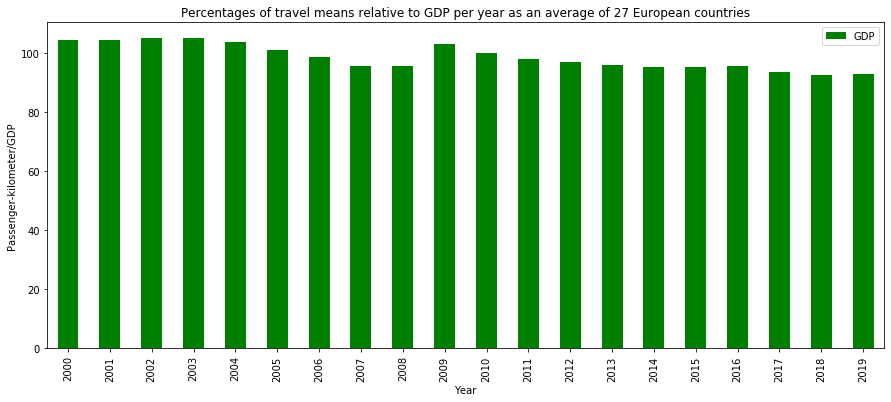

In [26]:
#get aggregated data for entire europe and sort for by year asc
gdp_yearly_europe=df_gdp[df_gdp["Country"]=="EU27_2020"].sort_values("Year").dropna()
ax=gdp_yearly_europe.plot(
  x = 'Year', 
  kind = 'bar', 
  stacked = True, 
  title = 'Percentages of travel means relative to GDP per year as an average of 27 European countries', 
  mark_right = True,
  color="green",
  figsize=(15, 6))
#set y axis limits
#ax.set_ylim(90,110)
ax.set_ylabel("Passenger-kilometer/GDP")

We have individually analyzed the GDP of several countries that can serve as an example to illustrate different GDP trends in the set of European countries. Below, the GDP in relation to passenger-kilometers undertaken are plotted for Switzerland (CH), France (FR), Greece (EL), and Portugal (PT).

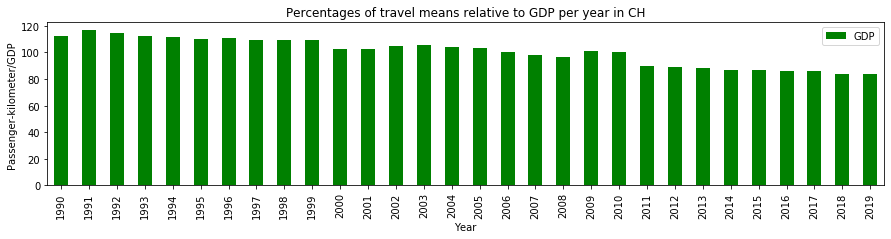

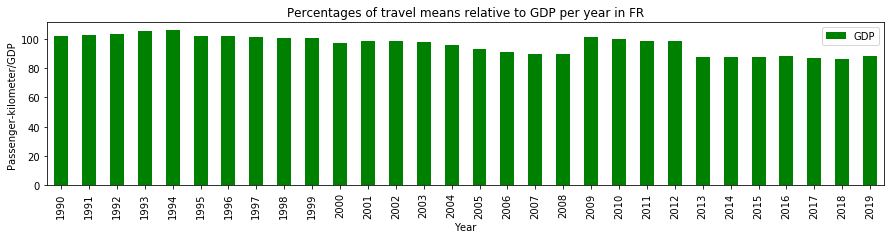

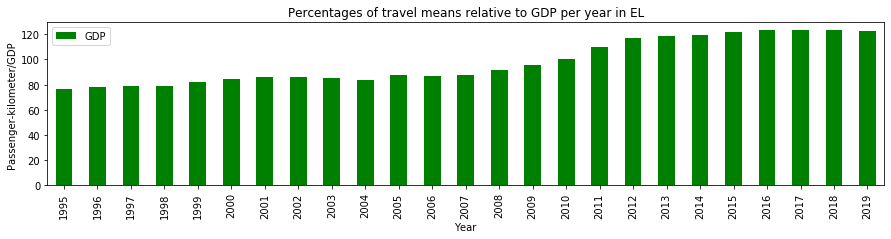

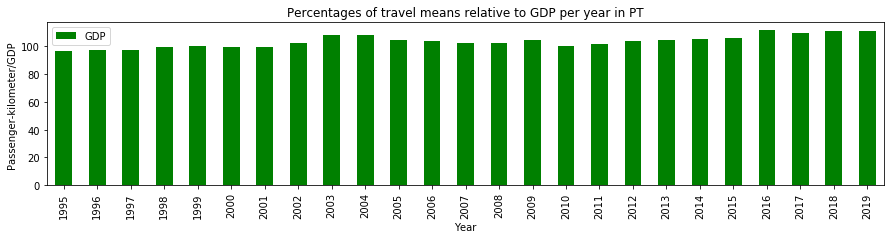

In [27]:
def plot_gdp_data_per_country():
    #countries=df_gdp["Country"].unique()
    countries=["CH", "FR", "EL", "PT"]
    for cnt in countries:
        gdp_yearly_europe=df_gdp[df_gdp["Country"]==cnt].sort_values("Year").dropna()
        ax=gdp_yearly_europe.plot(
          x = 'Year', 
          kind = 'bar', 
          stacked = True, 
          title = 'Percentages of travel means relative to GDP per year in '+cnt, 
          mark_right = True,
          color="green",
          figsize=(15,3))
        #set y axis limits
        #ax.set_ylim(90,110)
        ax.set_ylabel("Passenger-kilometer/GDP")
        
plot_gdp_data_per_country()

The GDP of countries such as Switzerland and France provide a good example of decreasing GDP-to-transport ratios, whereas Greece and Portugal have an increasing ratio. We argue that a higher GDP could indicate more wealth, and therefore would favor the usage of cars - as using, owning, and maintaining a car can be considered to be a substantial cost to a citizen. In the modal split behaviour of the countries with decreasing ratio we can see a very small decline in car usage, but a increase in train and bus usage, whereas several countries with increasing GDP ratio simultenously have in increasing GDP ratio trend over the course of the study period. 

The fact that many countries have started investing more into the train and bus infrastructure of cities could also be a reason for the decreasing trend in car usage for many countries, especially in Western Europe. 

# CO2 Emmisions

As a last result, and more of an effect than an affect, is the CO2 emissions that are created from new passenger cars per country. We originally considered it interesting to study not only the factors that contribute to modal split behaviour, but also result effects of the modal split usage. The CO2 emission from new passenger cars could therefore illustrate the effects of different kinds of modal split tendencies, where countries that tend to use car transportation could have higher emissions. 

Below, we show such CO2 emissions per country per year: 

In [28]:
#load dataset
df_co2=pd.read_csv("RelatedToTransport/Co2Emissions.csv")
df_co2

Country  Year  Co2Emission
0        AT  2000        168.0
1        BE  2000        166.5
2        DE  2000        182.2
3        DK  2000        175.7
4        EL  2000        180.3
..      ...   ...          ...
513      RO  2019        124.3
514      SE  2019        119.7
515      SI  2019        123.7
516      SK  2019        133.4
517      UK  2019        127.7

[518 rows x 3 columns]

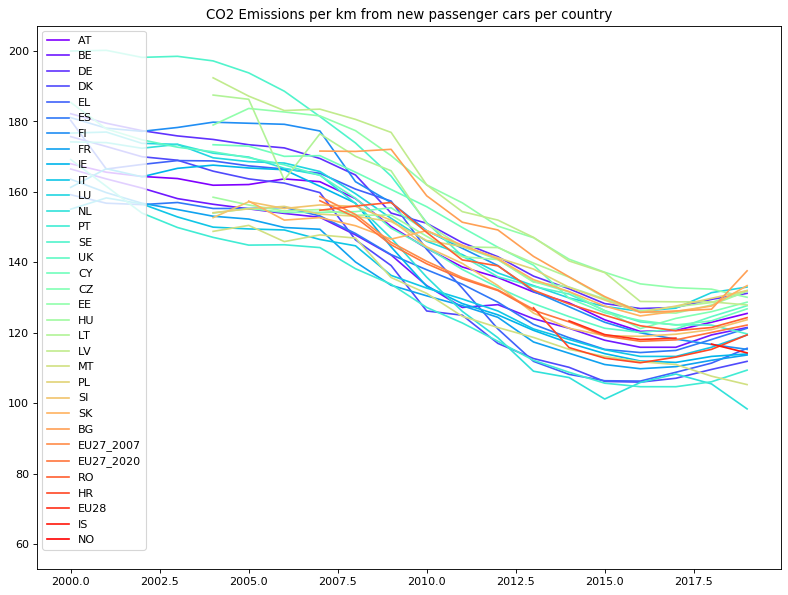

In [29]:
def plot_co2_emmisions_by_country(plot_title):  
    figure(figsize=(12, 9), dpi=80)
    #get list of countries
    countries=df_co2["Country"].unique()
    n=len(countries)
    #generate colors
    color = cm.rainbow(np.linspace(0, 1, n))
    i=0
    for country in countries:    
        plt.plot(df_co2[df_co2["Country"]==country]["Year"],df_co2[df_co2["Country"]==country]["Co2Emission"],c=color[i],label=country)
        i=i+1
    #show legend
    plt.legend()
    plt.title(plot_title)
    plt.show()
    
plot_co2_emmisions_by_country("CO2 Emissions per km from new passenger cars per country")  

Generally, it is difficult to draw conclusions simply from the CO2 emissions created by new passenger cars only. Nevertheless, it is interesting to see that the average CO2 emission per km has considerably decreased in time. 

## Network & correlation analysis

To conclude on the question of how modal split tendencies vary among countries, we wanted to provide a general overview and understand of how similar countries are in regard to modal split, and what effect certain factors have on the modal split behaviour. 

Therefore, we started visualization the modal split proportions in the form of nodes, grouped by car, train, and bus transport, to visualize the similarity of countries transportation preferences, where the size of each node presents the effect the vehicle transporation type has in the country. 

In [30]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [31]:
df = pd.read_csv('RelatedToTransport/ModalSplit.csv').pivot_table("ModalSplitKm",["Country", "VehicleType"],"Year").reset_index()

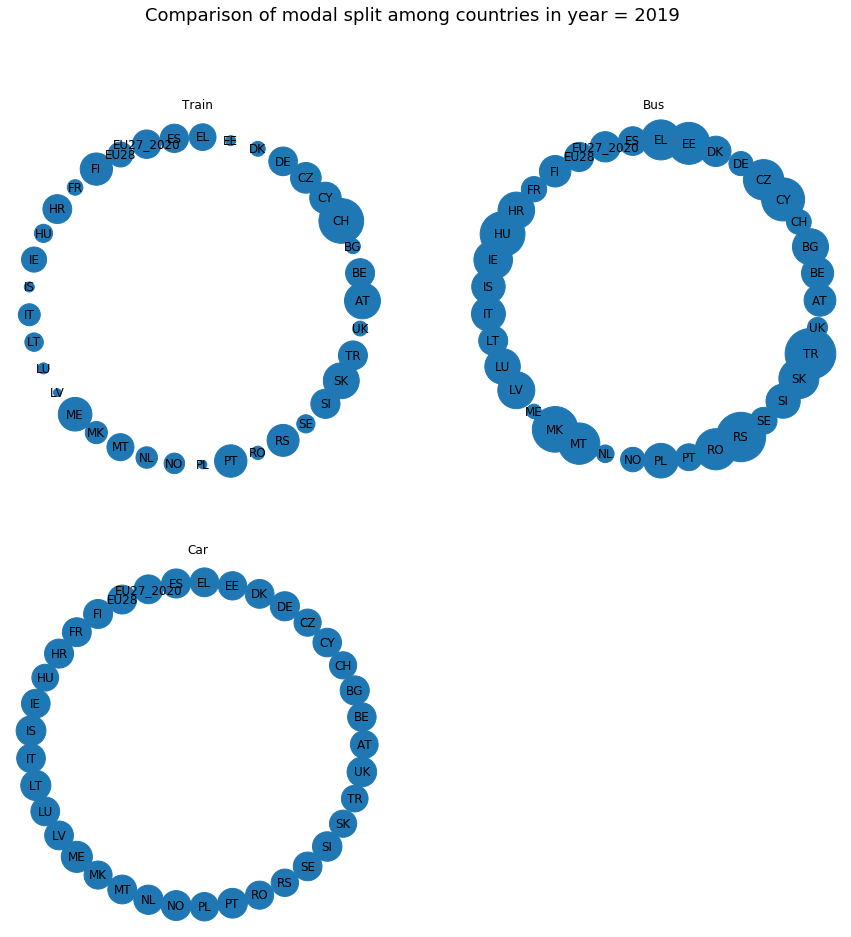

In [32]:
G = nx.Graph()

curr_year = 2019

# iterate over the rows of the dataframe
# for each row, create a node for the country and add modal split data for each mean of transportation
for index, row in df.iterrows():
    if(row['VehicleType'] == 'BUS_TOT'):
        G.add_node(row["Country"], year = curr_year, BUS_TOT = row[curr_year])
    elif(row['VehicleType'] == 'CAR'):
        G.add_node(row["Country"], year = curr_year, CAR = row[curr_year])
    elif(row['VehicleType'] == 'TRN'):
        G.add_node(row["Country"], year = curr_year, TRN = row[curr_year])
    else:
        G.add_node(row["Country"], year = curr_year, TRN_BUS_TOT_AVD = row[curr_year])

# node values used for the node size in the graph drawing methods
# some need a multiplier (i.e. 10, 100) to make the nodes a bit easier for comparison
a = list(v * 100 for v in nx.get_node_attributes(G,'TRN').values())
b = list(v * 100 for v in nx.get_node_attributes(G,'BUS_TOT').values())
c = list(v * 10 for v in nx.get_node_attributes(G,'CAR').values())
 
nodes = list(nx.get_node_attributes(G,'BUS_TOT').keys())

# node drawing methods
f, axes = plt.subplots(2, 2,figsize=(15, 15))
axs = axes.ravel()
axs[0].set_title("Train")
nx.draw_circular(G, nodelist = nodes, node_size = a, with_labels = True, ax = axs[0])
axs[1].set_title("Bus")
nx.draw_circular(G, nodelist = nodes, node_size = b, with_labels = True, ax = axs[1])
axs[2].set_title("Car")
nx.draw_circular(G, nodelist = nodes, node_size = c, with_labels = True, ax = axs[2])

f.delaxes(axs[3])
f.suptitle("Comparison of modal split among countries in year = 2019", fontsize = 18)
plt.show()

The `Car` transportation method seems to be quite the same among the list of countries here, as there is no visible outlier. For the `Bus` plot, we see that Hungary (HU) and Greece (EL) are the biggest in size, where the bus transport is heavily used, while countries like United Kingdom (UK) and Czech Republic (CH) have a very small amount of bus transportation use. On the other hand, we see *CH* dominating the `Train` graph plot, with other countries such as Austria (AT) and France (FR). This graph was done using data collected in year 2019.

### Most correlated countries in Europe based on bus transport

The following graphs are done using Pearson correlation among the modal split data collected for each country, so that the rows will be represented by the year , while the columns will be the names of the countries. Thus, the cell value will be the `ModalSplit` value for a country in a specific year (separated by means of transport, dataframe-wise). We then used a correlation matrix to observe which countries performed similar in changing the modal split among these years. 

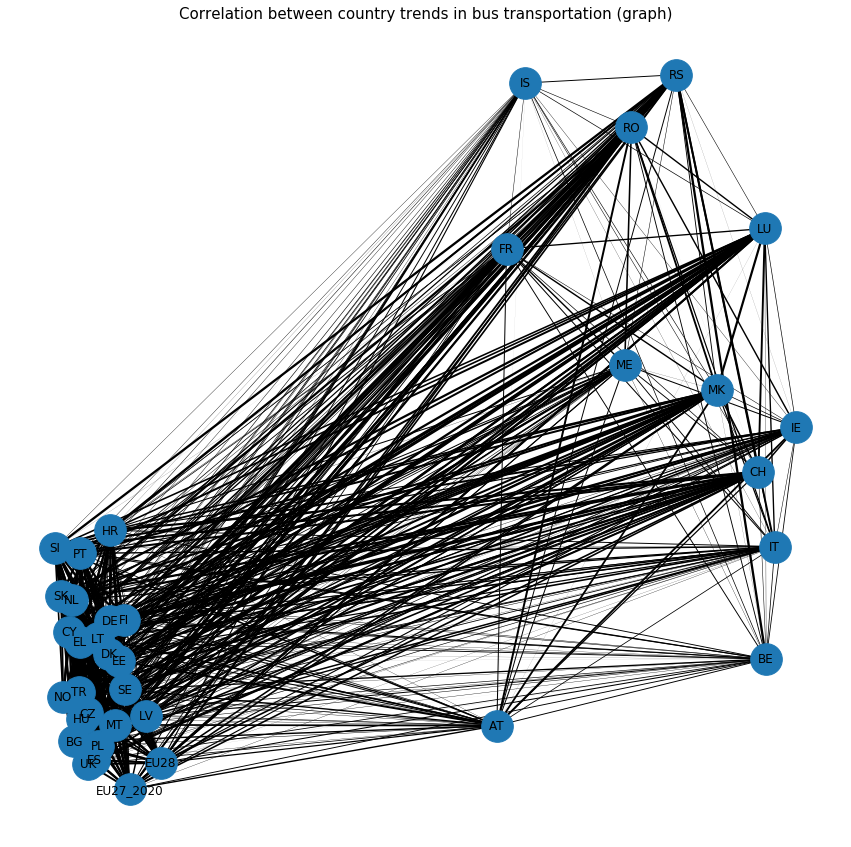

In [33]:
# create the correlation matrix for countries (rows - years, cols - countries)
# => p x p correlation matrix, p - number of countries
df_bus = df[df["VehicleType"] == "BUS_TOT"][["Country", 2019, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013 , 2014 , 2015, 2016 , 2017 , 2018]]
df_bus = df_bus.set_index('Country').T.corr()

# create the graph
G = nx.Graph()

for country in df_bus.index:
    G.add_node(country)

# add an edge based on 3 values:
# (source_node = country1, destination_node = country2, edge_value = correlation_between_country1_country2)
for i in range(1, df_bus.shape[0]):
    for j in range(i):
        G.add_edge(df_bus.index[j], df_bus.columns[i], value = df_bus.iloc[i, j])

edges = G.edges()
# add a multiplying coefficient for better graph plot comparison
weights = [2.5 * G[u][v]['value'] for u, v in edges]        


f, axes = plt.subplots(figsize=(15, 15))
axes.set_title("Correlation between country trends in bus transportation (graph)", fontdict={'fontsize': 15})
pos = nx.spring_layout(G, weight = 'value')
nx.draw(G, pos=pos, node_size = 1000, with_labels = True, width = weights, ax = axes)

What we can see from this clustering is that mainly three distinct clusters are built, where the most dense cluster consists of 20+ countries, whereas the remaining European countries are spread further away from each other - indicating less similarity among those countries for the bus transport. 

### Most correlated countries in Europe based on car transport

We move on to visualize the same kind of plot for the car transportation type.

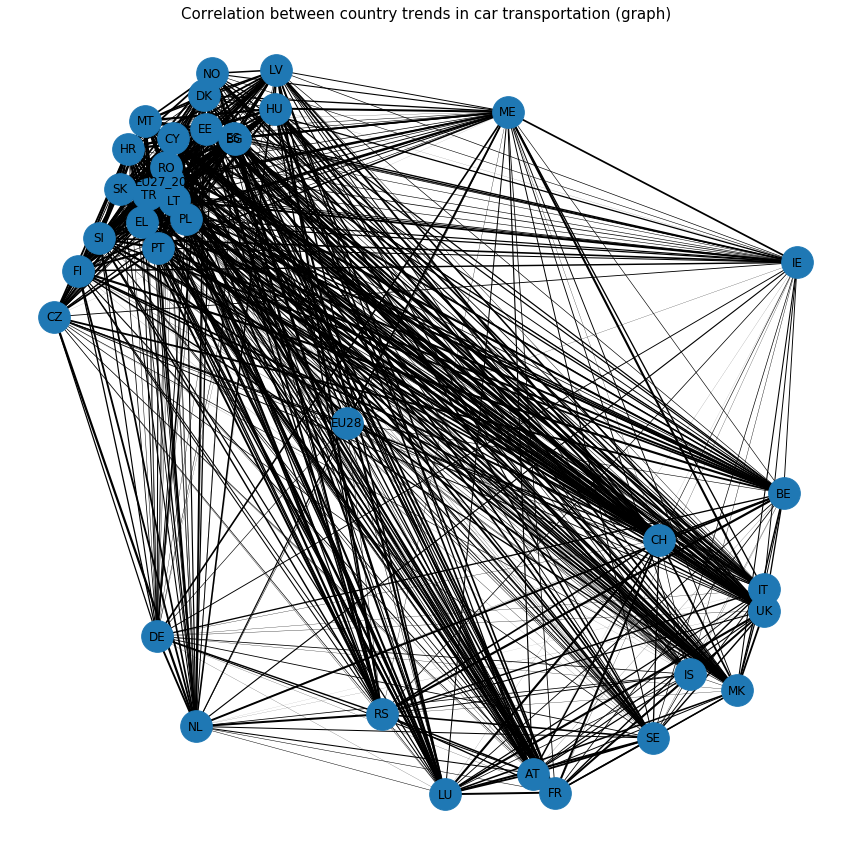

In [34]:
# create the correlation matrix for countries (rows - years, cols - countries)
# => p x p correlation matrix, p - number of countries
df_car = df[df["VehicleType"] == "CAR"][["Country", 2019, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013 , 2014 , 2015, 2016 , 2017 , 2018]]
df_car = df_car.set_index('Country').T.corr()

G = nx.Graph()

for country in df_car.index:
    G.add_node(country)

# add an edge based on 3 values:
# (source_node = country1, destination_node = country2, edge_value = correlation_between_country1_country2)
for i in range(1, df_car.shape[0]):
    for j in range(i):
        G.add_edge(df_car.index[j], df_car.columns[i], value = df_car.iloc[i, j])

edges = G.edges()
weights = [2.5 * G[u][v]['value'] for u, v in edges]        

f, axes = plt.subplots(figsize=(15, 15))
axes.set_title("Correlation between country trends in car transportation (graph)", fontdict = {'fontsize': 15})
pos = nx.spring_layout(G, weight='value')
nx.draw(G, pos=pos, nodelist = nodes, node_size = 1000, with_labels = True, width = weights, ax = axes)

Similarly to the previous plot, we can observe one large cluster with most countries contained within it, whereas the remaining ~15 countries are spread further away from each other. Interestingly, the european average of 28 European countries is centered directly in the middle of all those countries. 

### Most correlated countries in Europe based on train transport

In [35]:
# create the correlation matrix for countries (rows - years, cols - countries)
# => p x p correlation matrix, p - number of countries
df_train = df[~df["Country"].isin(["CY", "IS", "MT"])]
df_train = df_train[df_train["VehicleType"] == "TRN"][["Country", 2019, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013 , 2014 , 2015, 2016 , 2017 , 2018]]
df_train = df_train.set_index('Country').T.corr()

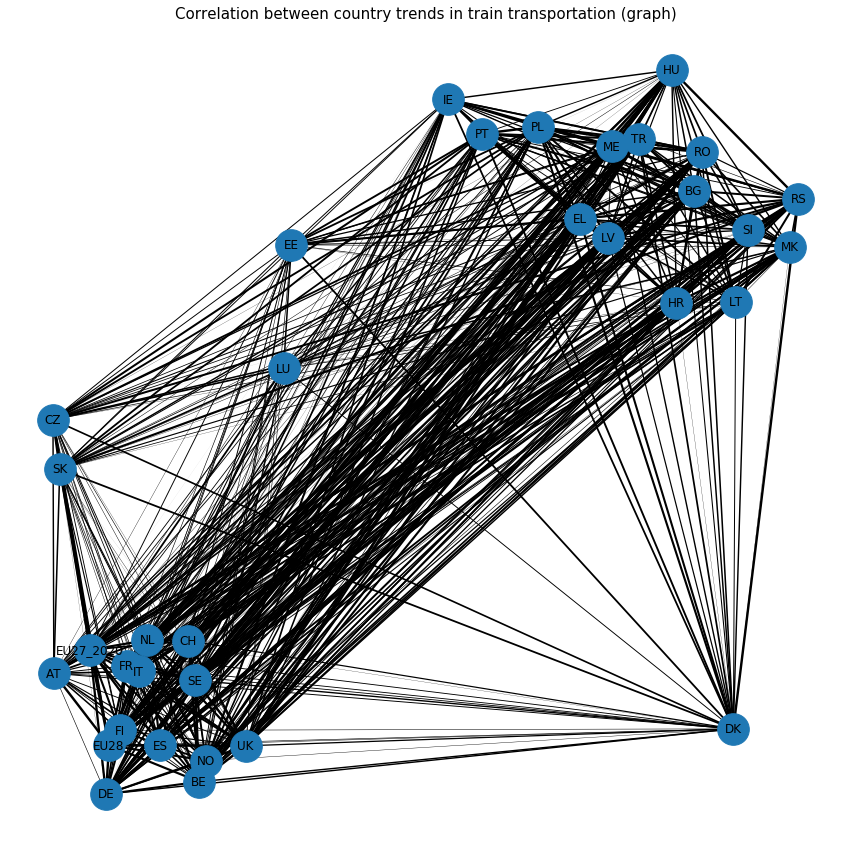

In [36]:
G = nx.Graph()

for country in df_train.index:
    G.add_node(country)

# add an edge based on 3 values:
# (source_node = country1, destination_node = country2, edge_value = correlation_between_country1_country2)
for i in range(1, df_train.shape[0]):
    for j in range(i):
        G.add_edge(df_train.index[j], df_train.columns[i], value = df_train.iloc[i, j])
edges = G.edges()
weights = [2.5 * G[u][v]['value'] for u, v in edges]        

f, axes = plt.subplots(figsize=(15, 15))
axes.set_title("Correlation between country trends in train transportation (graph)", fontdict = {'fontsize': 15})
pos = nx.spring_layout(G, weight='value')
nx.draw(G, pos=pos, node_size = 1000, with_labels = True, width = weights, ax = axes)

In contrast to car and bus transport, there seems to be more similarity in train transportation behaviour among countries, as there are two distinct clusters formed, with only a handful of countries spread away from them. 

# Correlations between ModalSplit and other metrics related to means of transport in a country

These plots are made to study and find which external factors are related (and maybe have an impact) on the modal split values for each country. We study other factors such as the GDP and the status of the transportation infrastructure (ex. total length of railways in a country, motorways, how many deaths occur in traffic, how much people travel (in km) using these means etc.). For each country, we separate the data by the means of transport and study the correlation between the measured `ModalSplitKm` variable, describing the modal split impact of a type of vehicle in a country, and the external factors. In this report, we only include the correlation matrices of two countries, Slovakia and Portugal, because of the length of the current report. 

The correlation heatmap is plotted for each vehicle type individually, and should help visualizing what effects the above mentioned factors have on the modal split tendencies of a country.

In [37]:
df = pd.read_csv("RelatedToTransport/All_data_inner_join_by_country_and_year.csv")
# drop the modal split measured for the total, as it is redundant (a sum of the other three)
df = df.drop(df[df["ModalSplit_VehicleType"] == 'TRN_BUS_TOT_AVD'].index)
# one hot encoding of the transportation means
one_hot = pd.get_dummies(df["ModalSplit_VehicleType"])
df.drop('ModalSplit_VehicleType', axis = 1, inplace=True)
df = df.join(one_hot)

### Bus transportation

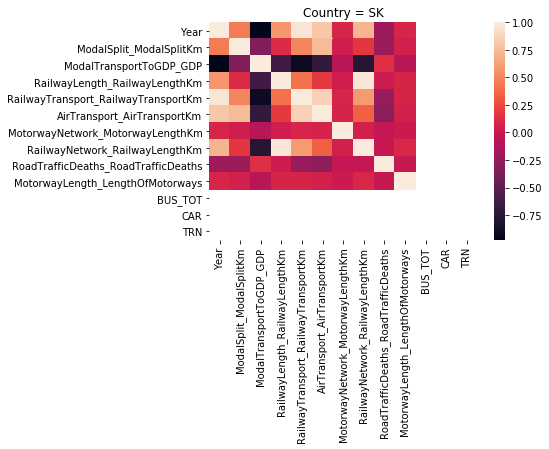

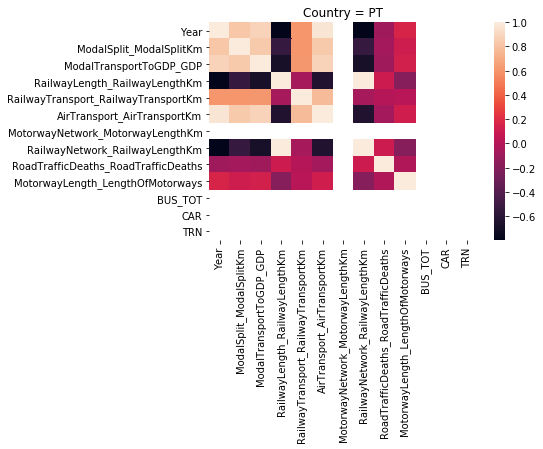

In [38]:
#for country in df["Country"].unique():
for country in ["SK", "PT"]:
    plt.figure()
    heatmap = sns.heatmap(df[(df["BUS_TOT"] == 1) & (df["Country"] == country)].corr())
    heatmap.set_title('Country = ' + country)

### Car transportation

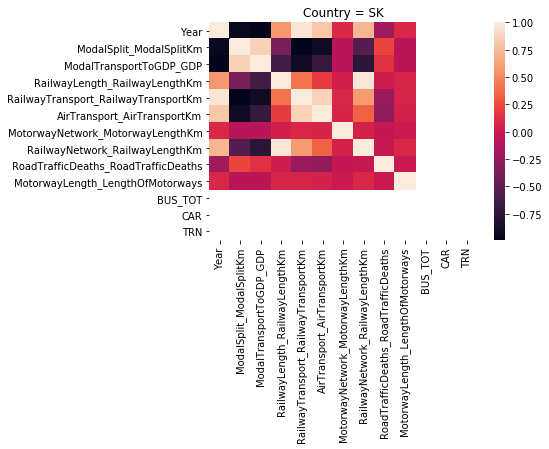

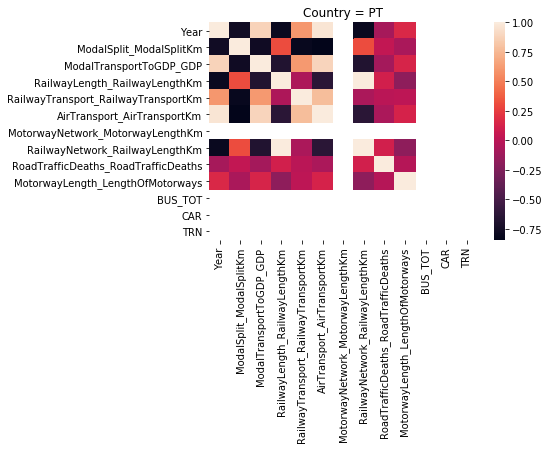

In [39]:
#for country in df["Country"].unique():
for country in ["SK", "PT"]:
    plt.figure()
    heatmap = sns.heatmap(df[(df["CAR"] == 1) & (df["Country"] == country)].corr())
    heatmap.set_title('Country = ' + country)

### Train transportation

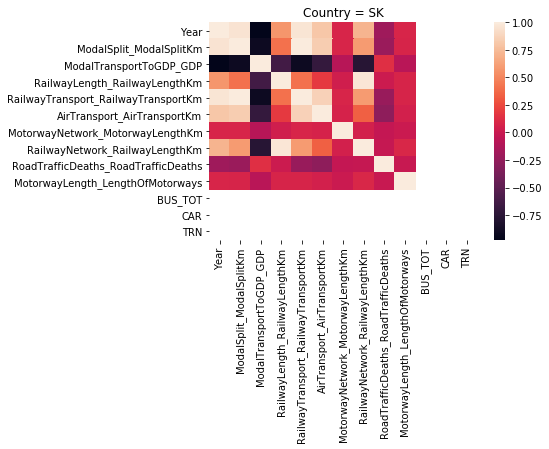

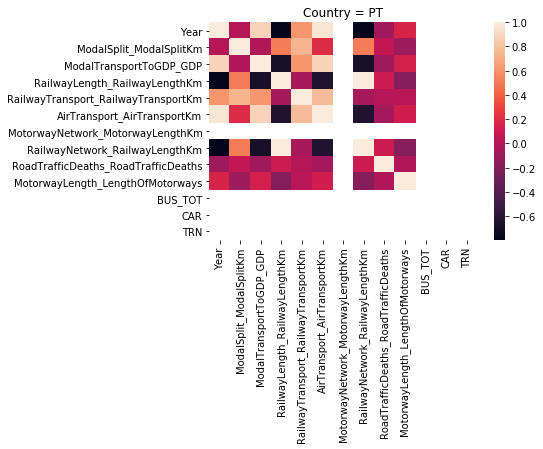

In [40]:
#for country in df["Country"].unique():
for country in ["SK", "PT"]:
    plt.figure()
    heatmap = sns.heatmap(df[(df["TRN"] == 1) & (df["Country"] == country)].corr())
    heatmap.set_title('Country = ' + country)

## Explaining the approach of correlation heatmaps

The purpose of using correlation to estimate the effect on modal split is to get a better idea in what way the tendencies are affected. If, for example, we can see a positive correlation between train transport usage and the railway length within a country, it could indicate that the larger the train infrastructure within a country is, the more citizens will start using the train as their main transportation type. Such effect is seen for both Slovakia and Portugal (and more countries that are not visualized here), as the train usage is positively correlated to the railway length of a country. 

Similarly, the conclusion made on the GDP of a country can be further validated using the correlation between the GDP ratio and different vehicle type usages. In Slovakia, for example, a larger GDP ratio is positively correlated to more car usage, wheras there is a negative correlation between the GDP ratio and train usage. Nevertheless, such interpretation is country dependent and does not occur for all countries, like Portugal. Here, higher GDP ratios are positively correlated with bus transport, but are negatively correlated with car and train transport.

Concluding, the correlation between modal split and various factors that we studied is country-dependent and is difficult to generalize. Generally, the analyzed countries can be placed in 2-3 distinct groups that share similar tendencies. 

# Random forest for ModalSplit target variable

The last study performed was done using a random forest regression, having a similar goal to the previous one: trying to study the impact of the external factors on the `ModalSplit`. In order to do this, we trained a random forest regressor model on the full dataset, with the target variable `ModalSplit_ModalSplitKm`. Once the model has been fit, we study the `_feature_importances` value of the model, which gives us the most important features, having the highest weight, used in case we want to predict future values for this target variable. We can study this matter in a top-down approach, since the feature found in the root node of the tree has the highest importance, followed by the one in subsequent child nodes. There are also bar plots which show the importance of the features in a decreasing order (the values measured and shown as bars are relative to each other). We perform the model training for each vehicle type and visualize the tree structure for each of them below:

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# create a copy of the original dataframe to work on it for this study
df_rf = df

# one-hot encoding of the non-numeric variables
for col in ['MotorwayNetwork_Unit', 'RoadTrafficDeaths_Unit', 'MotorwayLength_TypeOfRoad']:
    one_hot = pd.get_dummies(df_rf[col])
    df_rf.drop(col, axis = 1, inplace=True)
    df_rf = df_rf.join(one_hot)

# separate the dataframe by means of transportation
bus_df = df_rf[(df_rf["RoadTrafficDeaths_TypeOfRoad"] == 'MWAY') & (df_rf["BUS_TOT"] == 1)]
car_df = df_rf[(df_rf["RoadTrafficDeaths_TypeOfRoad"] == 'MWAY') & (df_rf["CAR"] == 1)]
train_df = df_rf[(df_rf["RoadTrafficDeaths_TypeOfRoad"] == 'MWAY') & (df_rf["TRN"] == 1)]

### Bus transportation

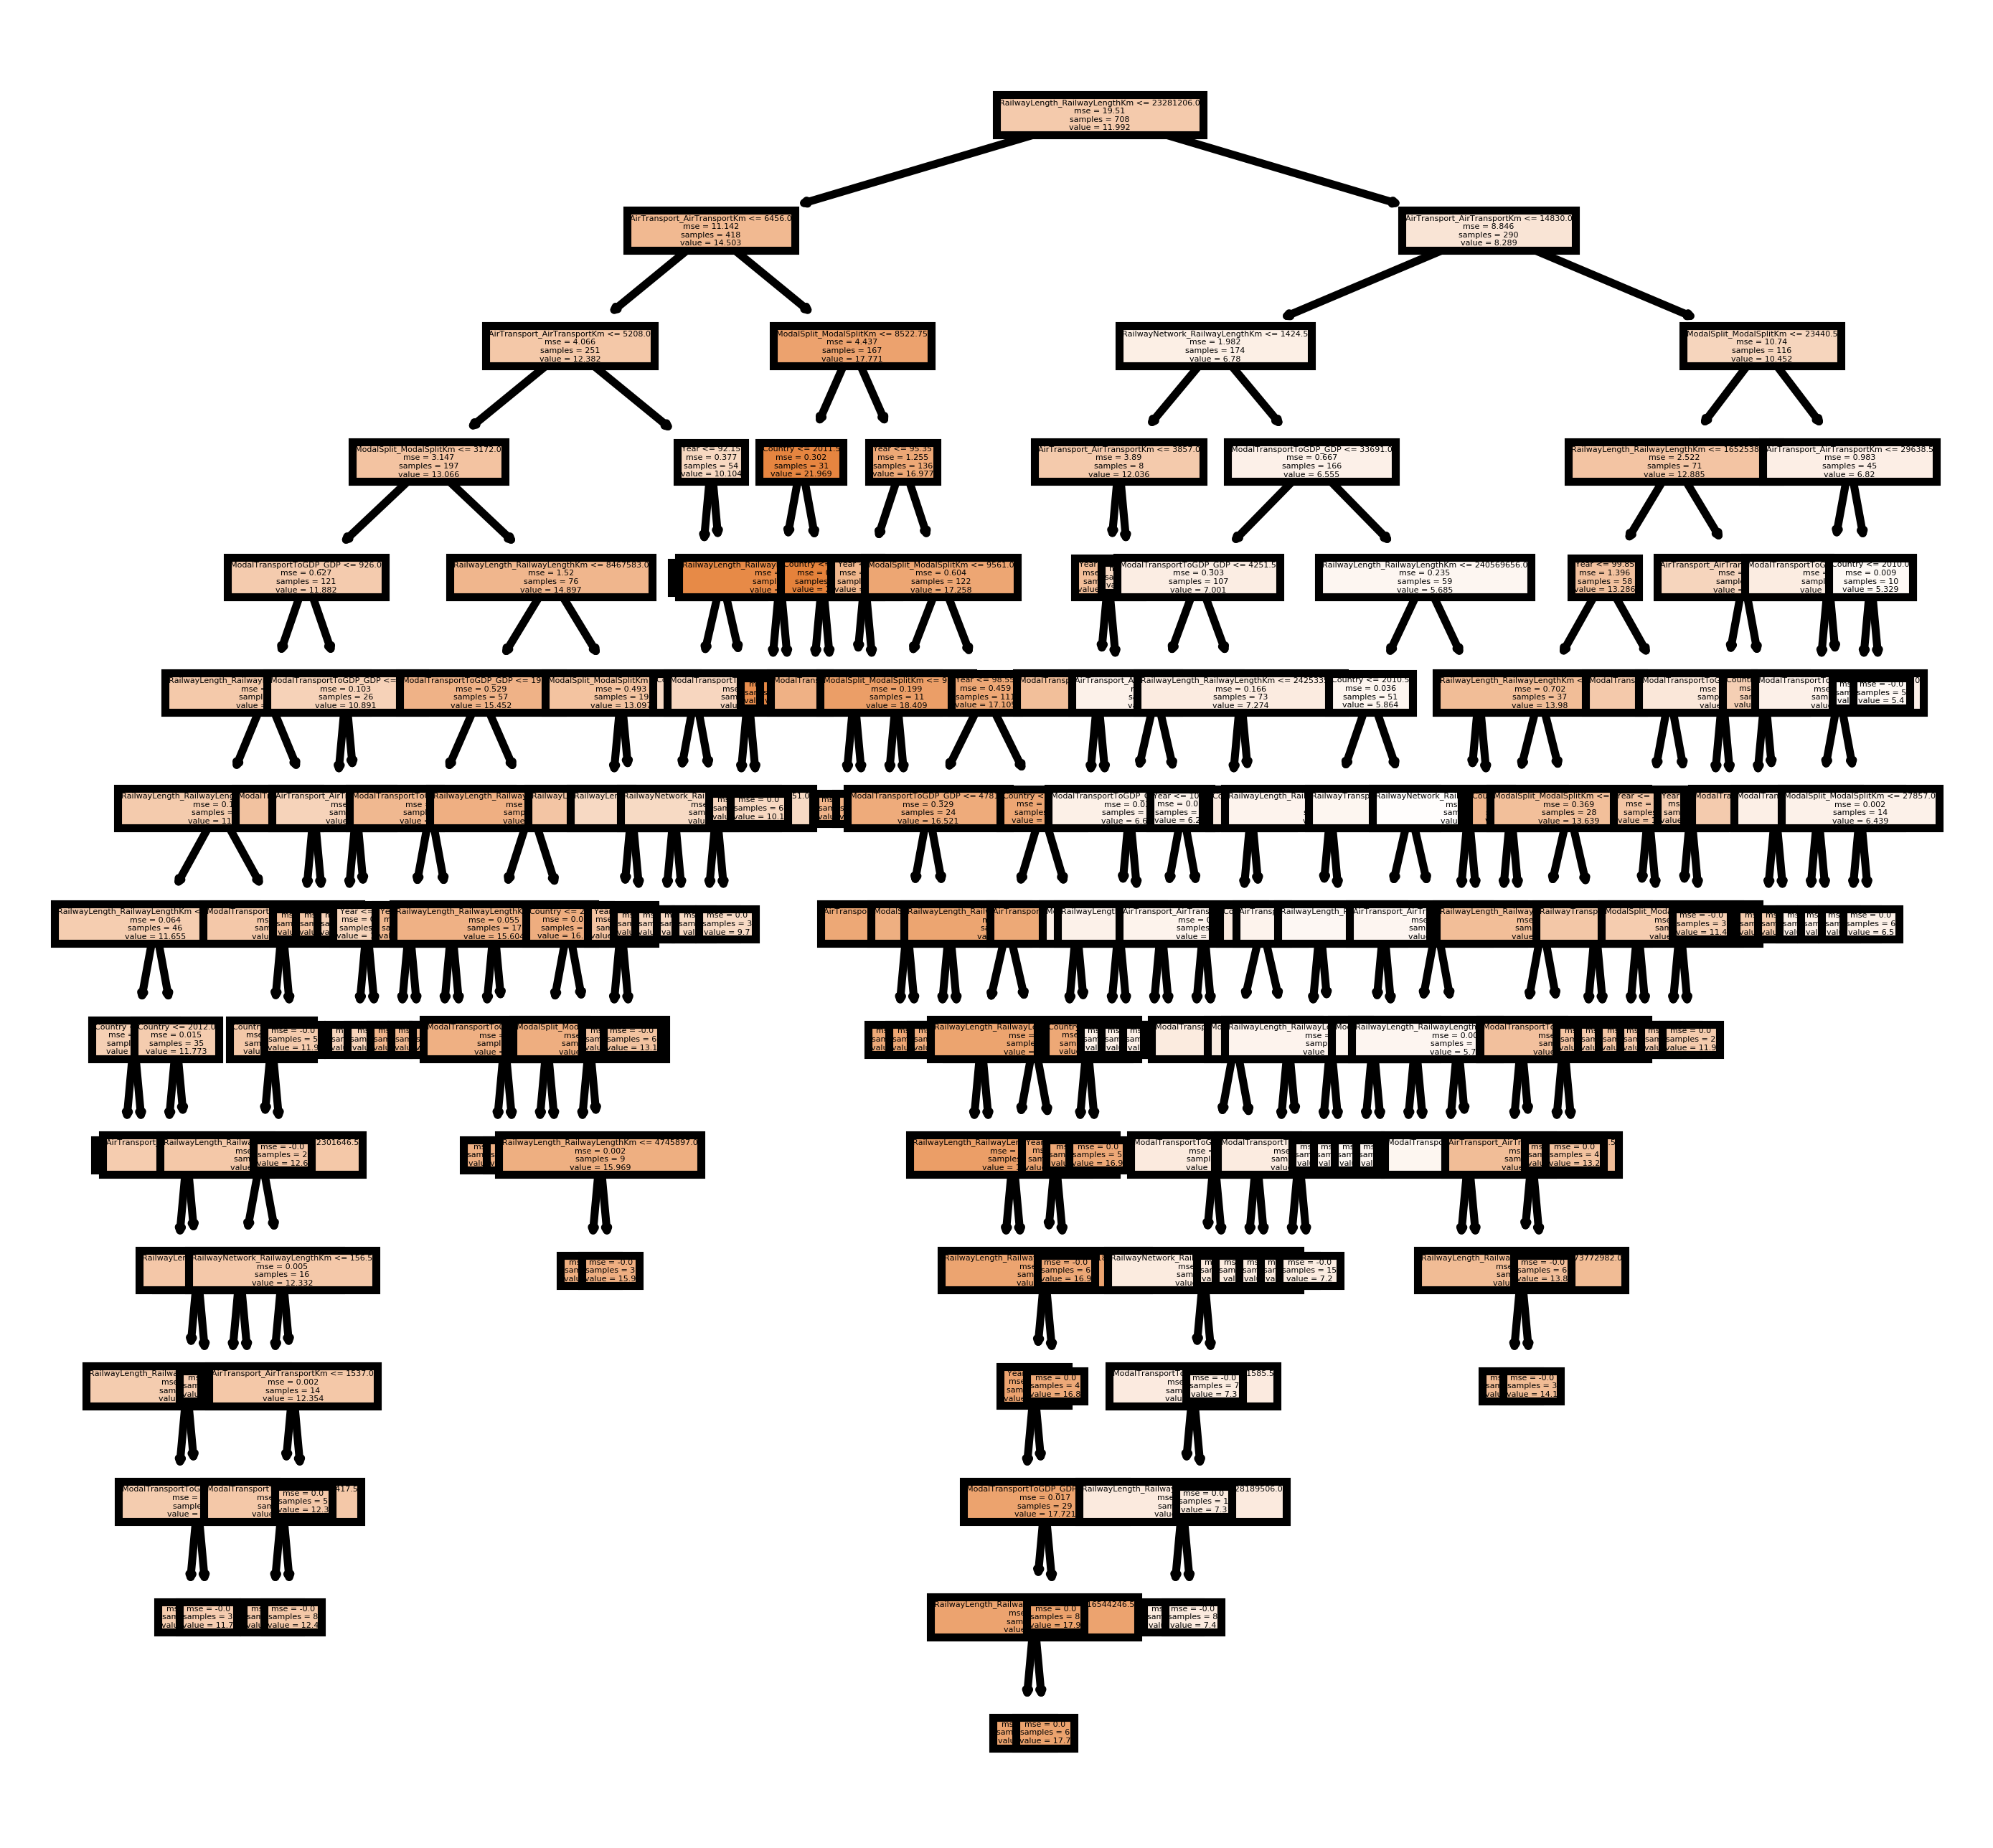

In [42]:
# drop irrelevant columns
X = bus_df.drop(['Country', 'ModalSplit_ModalSplitKm', 'RoadTrafficDeaths_TypeOfRoad'], axis = 1)
# set target variable
y = bus_df["ModalSplit_ModalSplitKm"]

# train (fit) a random forest regression model
bus_regr = RandomForestRegressor()
bus_regr.fit(X, y)

# plot the resulting estimator tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(bus_regr.estimators_[0],
               feature_names  = bus_df.drop(['CAR', 'BUS_TOT', 'TRN'], axis = 1).columns,
               filled = True);
fig.savefig('bus_rf_individualtree.png')

### Car transportation

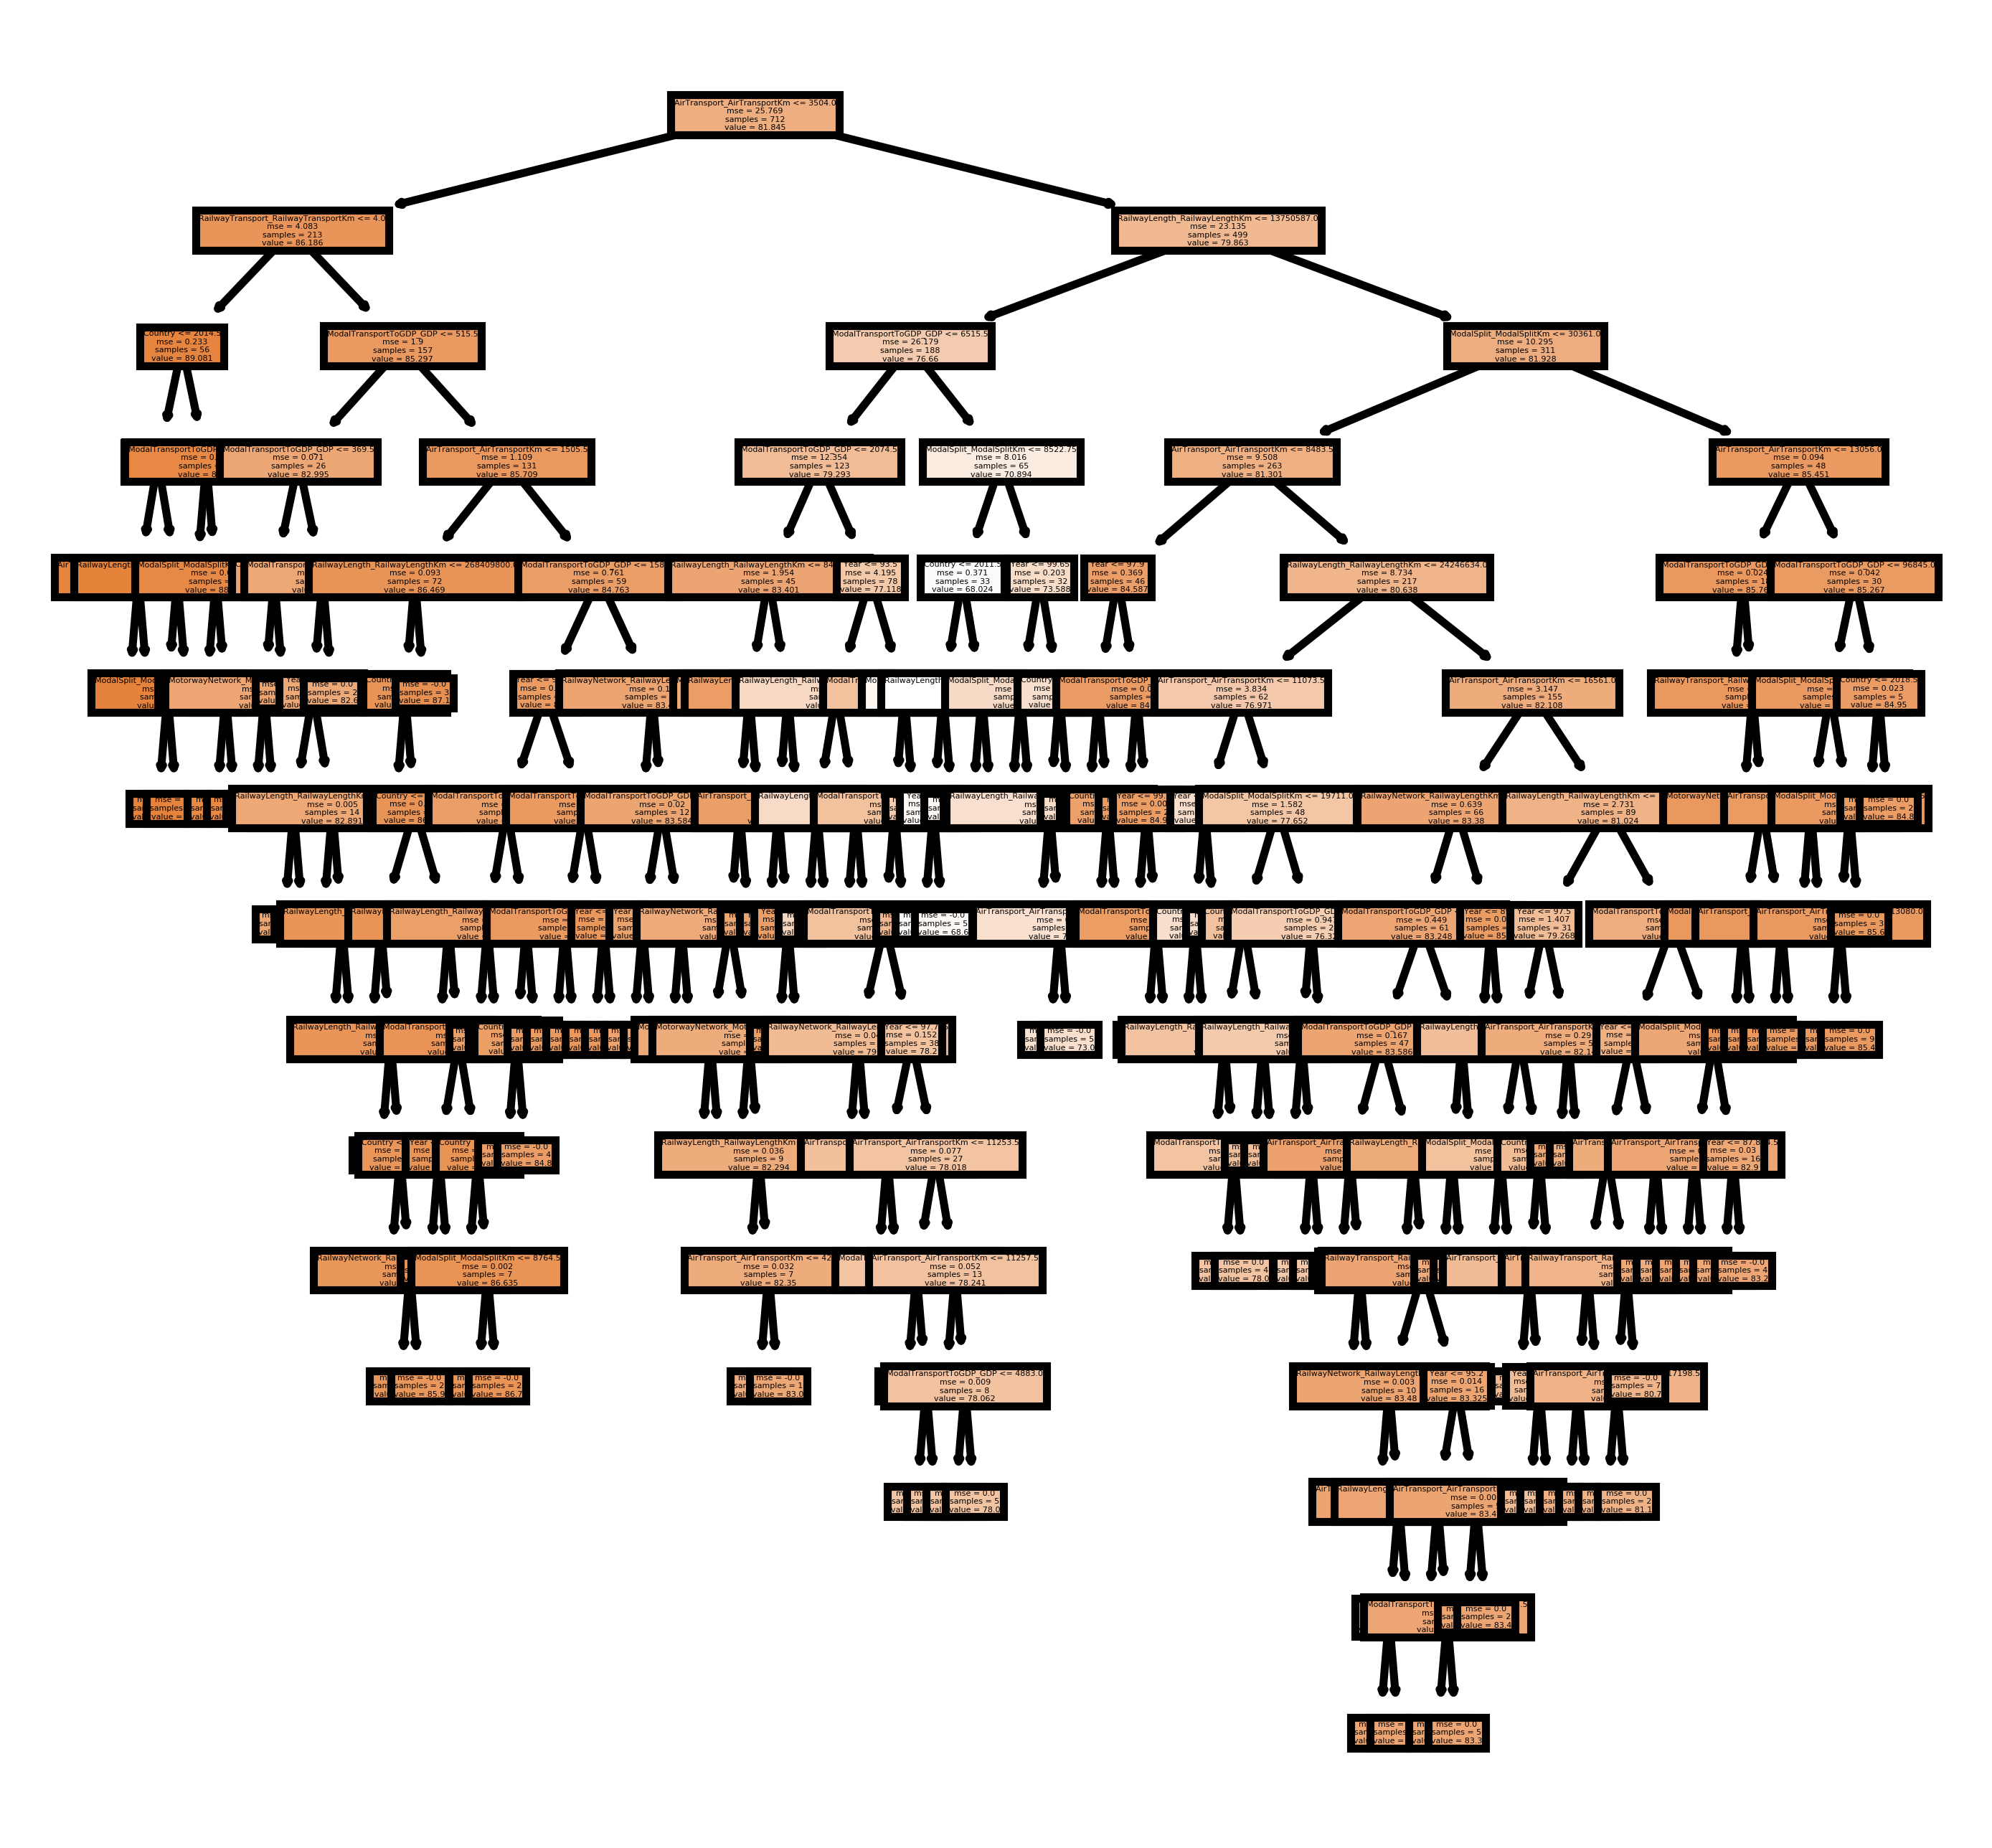

In [43]:
# drop irrelevant columns
X = car_df.drop(['Country', 'ModalSplit_ModalSplitKm', 'RoadTrafficDeaths_TypeOfRoad'], axis = 1)
# set target variable
y = car_df["ModalSplit_ModalSplitKm"]

# train (fit) a random forest regression model
car_regr = RandomForestRegressor()
car_regr.fit(X, y)

# plot the resulting estimator tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(car_regr.estimators_[0],
               feature_names  = car_df.drop(['CAR', 'BUS_TOT', 'TRN'], axis = 1).columns,
               filled = True);
fig.savefig('car_rf_individualtree.png')

### Train transportation

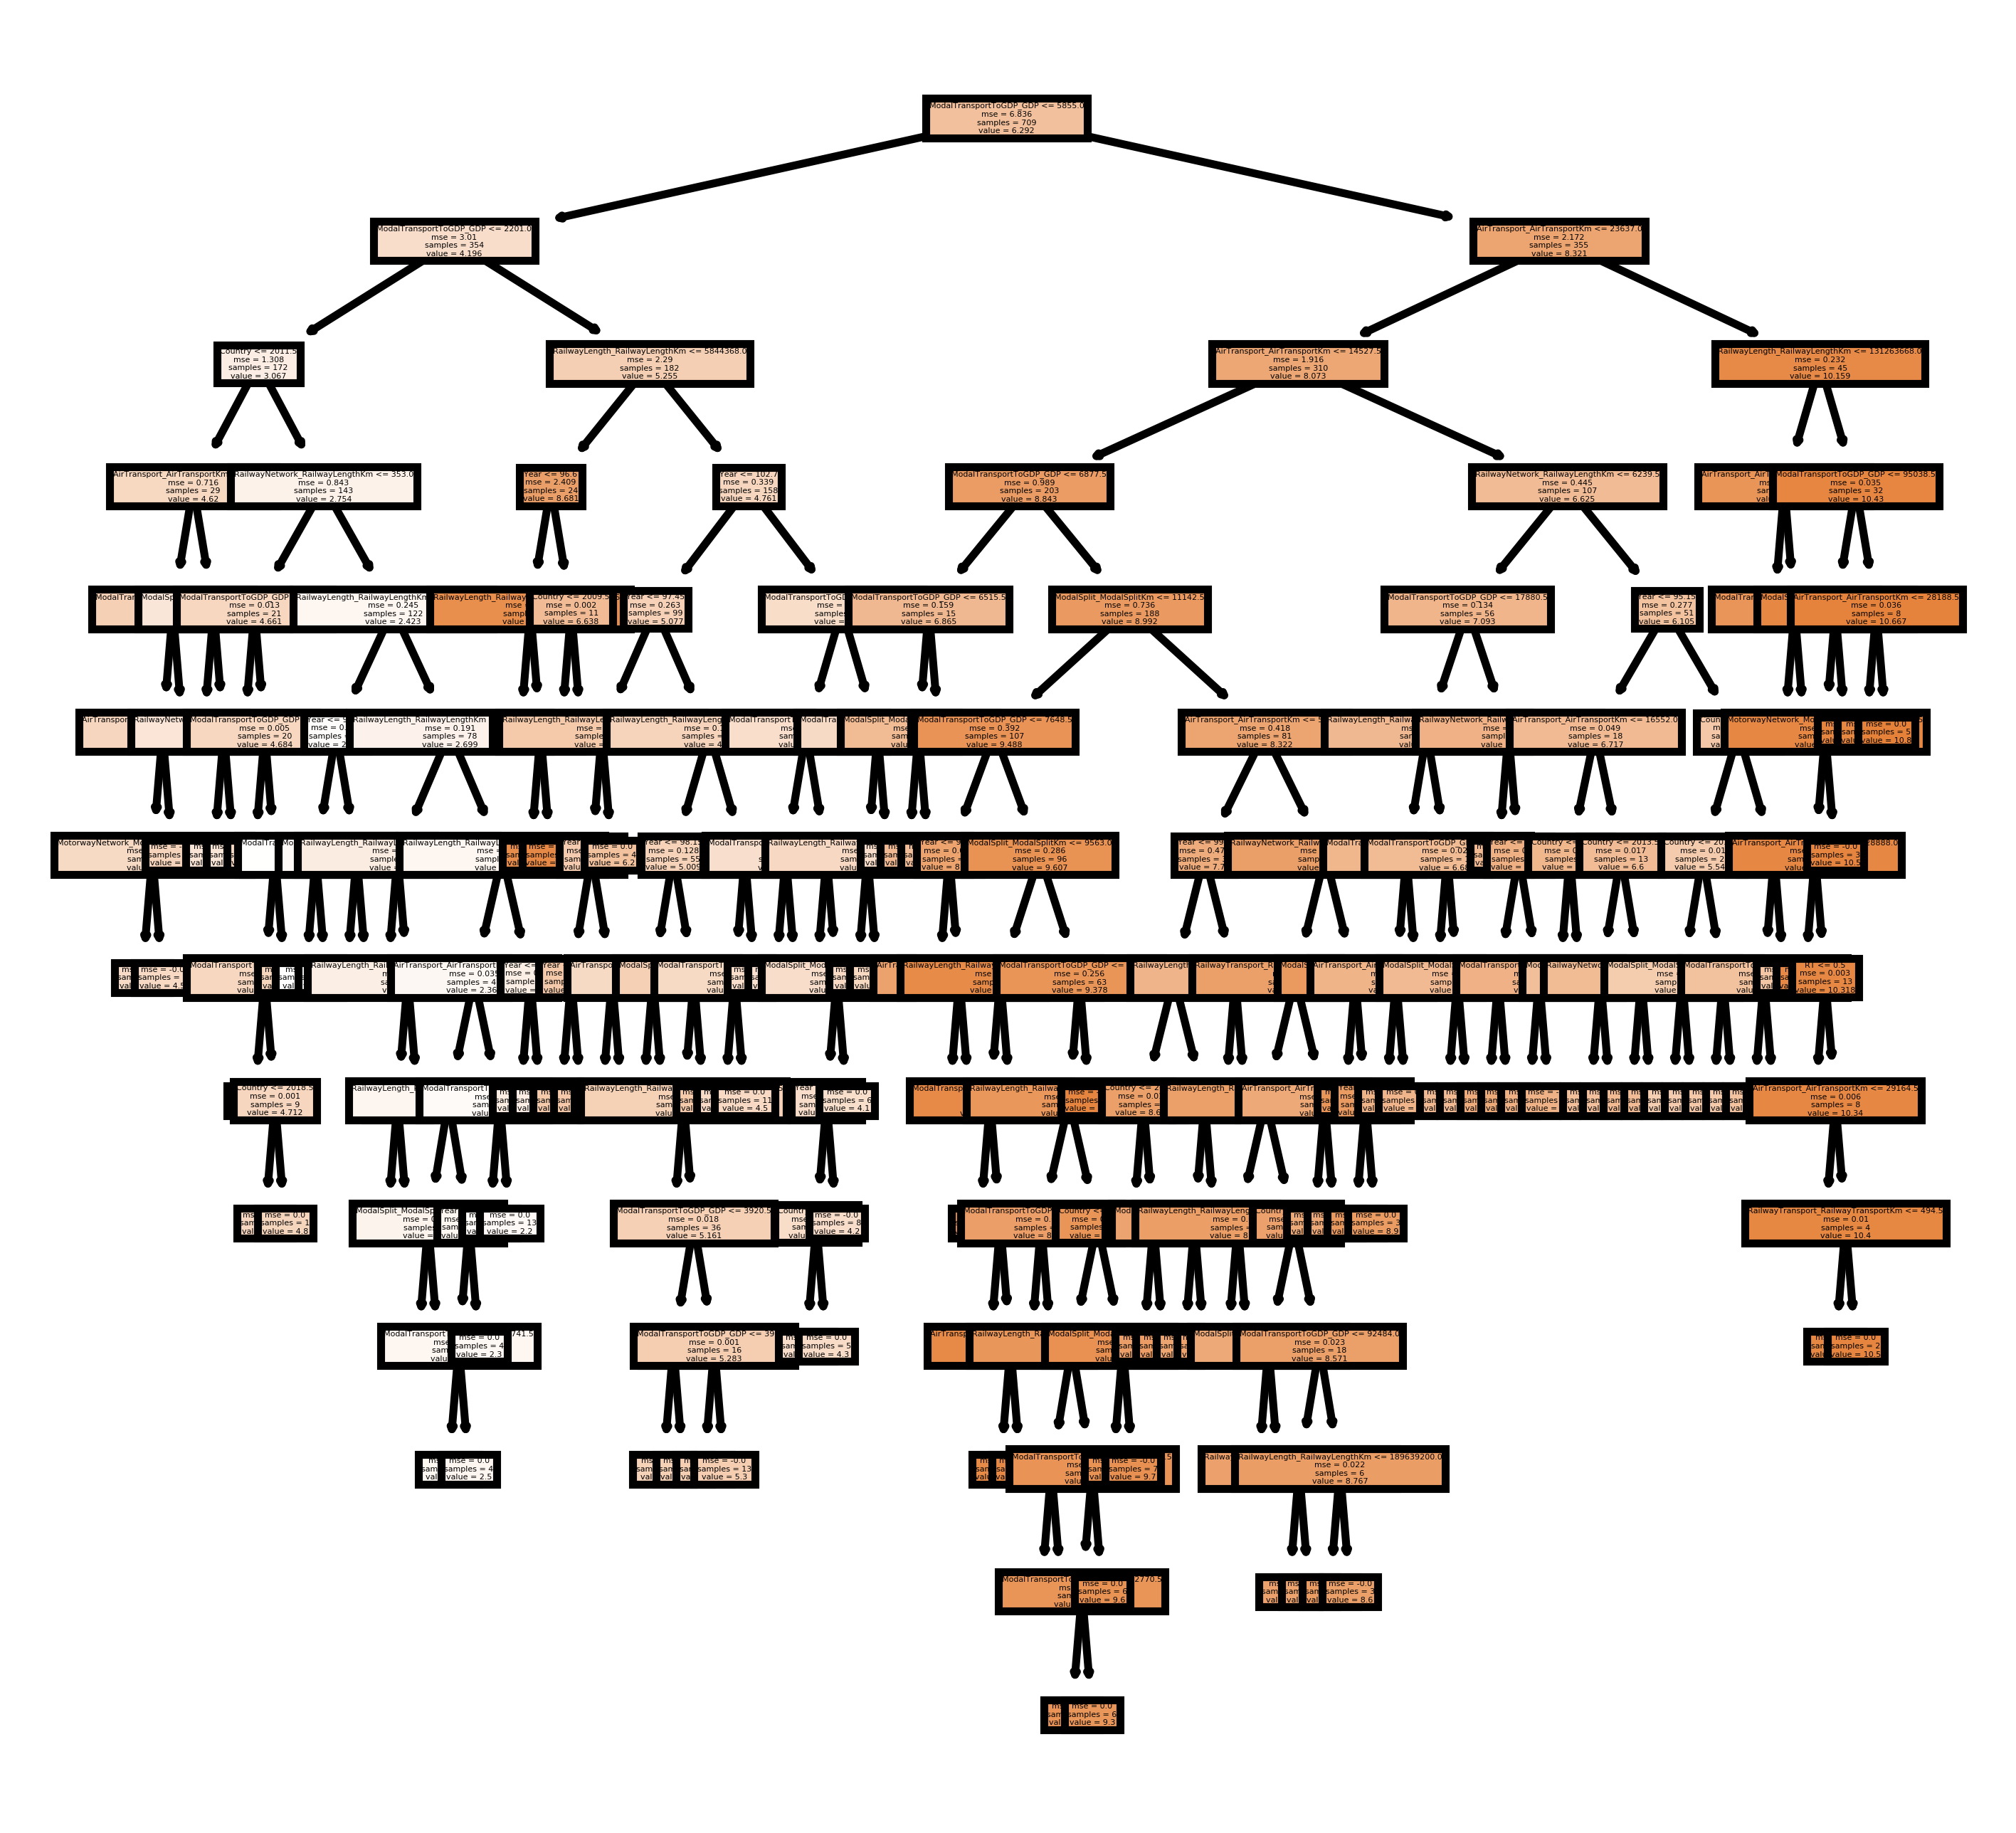

In [44]:
# drop irrelevant columns
X = train_df.drop(['Country', 'ModalSplit_ModalSplitKm', 'RoadTrafficDeaths_TypeOfRoad'], axis = 1)
# set target variable
y = train_df["ModalSplit_ModalSplitKm"]

# train (fit) a random forest regression model
train_regr = RandomForestRegressor()
train_regr.fit(X, y)

# plot the resulting estimator tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(train_regr.estimators_[0],
               feature_names  = train_df.drop(['CAR', 'BUS_TOT', 'TRN'], axis = 1).columns,
               filled = True);
fig.savefig('train_rf_individualtree.png')

## Feature importance

The feature importance is a resulting analysis that can be drawn from the random forest model trained above. It is a measure of how much impact a feature has on the structure of the forrest, meaning that if a factor was changed, how the overall tree structure and the predictions would change. In all feature importance plots below, there is a shared set of factors - such as the railway-length, the air and train transport, and the GDP of a country - that have a significant impact on the modal split proportions.  

### Bus

Text(0.5, 0, 'Random Forest Feature Importance')

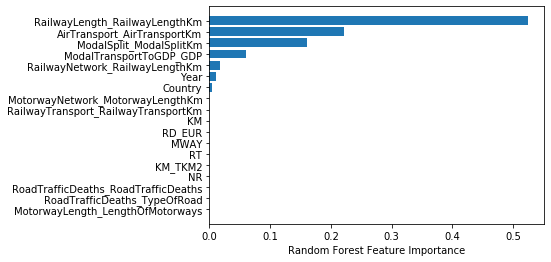

In [45]:
# sort the features by their importance
sorted_idx = bus_regr.feature_importances_.argsort()
plt.barh(bus_df.drop(['CAR', 'BUS_TOT', 'TRN'], axis = 1).columns[sorted_idx], bus_regr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Car

Text(0.5, 0, 'Random Forest Feature Importance')

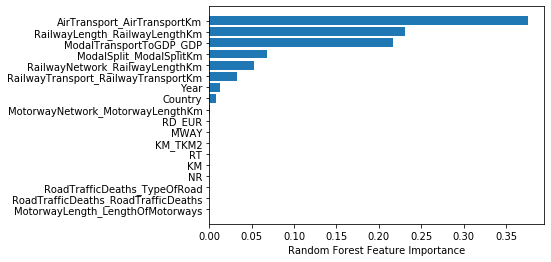

In [46]:
# sort the features by their importance
sorted_idx = car_regr.feature_importances_.argsort()
plt.barh(car_df.drop(['CAR', 'BUS_TOT', 'TRN'], axis = 1).columns[sorted_idx], car_regr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Train

Text(0.5, 0, 'Random Forest Feature Importance')

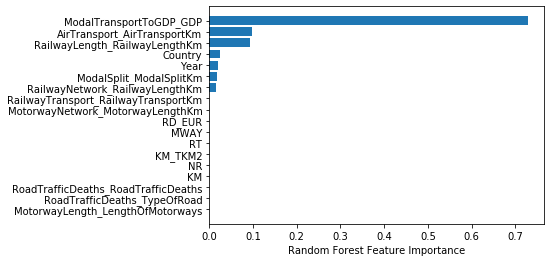

In [47]:
# sort the features by their importance
sorted_idx = train_regr.feature_importances_.argsort()
plt.barh(train_df.drop(['CAR', 'BUS_TOT', 'TRN'], axis = 1).columns[sorted_idx], train_regr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")